In [1]:
import datetime
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.font_manager as fm
import matplotlib.gridspec as gs
from mpl_toolkits.mplot3d import axes3d
from scipy.signal import welch
from scipy.signal.windows import hamming
from scipy.signal import welch
from scipy.signal.windows import hamming
import scipy.io

In [2]:
# msToProcess: O valor é ajustado de forma a garantir que todos subquadros sejam processados e incluídos na saída do sistema.
# Os primeiros 1000 milissegundos (1 segundo) podem ser excluídos para lidar com qualquer resposta transitória que ocorra no
#  início do processamento.
# IF: Frequência Intermediária do sinal GPS signal, Hz
# Frequência na qual o sinal GPS é amostrado
# acqSearchBand: especifica a faixa de frequência em que o sistema irá procurar os sinais dos satélites. 
# Esse valor é dado em kHz (quilohertz), sendo um número inteiro. A faixa de frequência definida por acqSearchBand é centrada 
# ao redor da frequência intermediária (IF), ou seja, a faixa de pesquisa será construída em torno da frequência IF.
# acqThreshold: Limiar do detector

# fileNameStr='C:\Repository\SoftGNSS\GNSS_signal_records\GPSdata-DiscreteComponents-fs38_192-if9_55.bin'
# msToProcess = 37000.0
# numberOfChannels = 8
# IF = 9548000.0
# samplingFreq = 38192000.0
# acqSearchBand = 14.0
# acqThreshold = 2.5
# pllDampingRatio = 0.7
# dllCorrelatorSpacing = 0.5
# elevationMask = 10.0

# fileNameStr=r'C:\Repository\GPSL1-DPEmodule\IF_Data_Set\Open Sky GPS L1.dat'
# msToProcess = 110000
# numberOfChannels = 12
# IF = 0
# samplingFreq = 10000000
# acqSearchBand = 7000
# acqThreshold = 1.8
# pllDampingRatio = 0.707
# dllCorrelatorSpacing = 0.3
# elevationMask = 0


fileNameStr=r'C:\Repository\GPSL1-DPEmodule\IF_Data_Set\Medium Urban in TST with one NLOS.dat'


msToProcess = 110000
numberOfChannels = 12
IF = 0
samplingFreq = 26000000
acqSearchBand = 7000
acqThreshold = 1.8
pllDampingRatio = 0.707
dllCorrelatorSpacing = 0.3
elevationMask = 0
resamplingThreshold = 8e6 # [Hz]
# Enable/dissable use of downsampling for acquisition
# 0 - Off
# 1 - On
resamplingflag         = 0 



# Check the number of arguments ==========================================
if fileNameStr is None:
    if not isinstance(fileNameStr, str):
         raise TypeError('File name must be a string')

In [3]:
skipNumberOfBytes = 0
fileName = fileNameStr
dataType = 'int8'
codeFreqBasis = 1023000.0
codeLength = 1023
skipAcquisition = False
acqSatelliteList = range(1, 33)
dllNoiseBandwidth = 2.0
pllNoiseBandwidth = 25.0
navSolPeriod = 500.0
useTropCorr = True
plotTracking = True
c = 299792458.0
startOffset = 68.802
dllDampingRatio = 0.707
fileType = 2
MMT = 0
DPE_nonCohInt = 1
DPE_cohInt = 20
DPE_latlong_span = 30
DPE_height_span = 50
DPE_clkBias_span = 20
CNo_accTime = 0.001
CNo_VSMinterval = 40



# dataType: 'schar'
# fileType: 2
# resamplingThreshold: 8000000
# resamplingflag: 0
# dllDampingRatio: 0.707
# truePosition: [1×1 struct]
# plotTracking: 0
# CNo: [1×1 struct]
# gt_llh: [22.299866 114.180036 16]
# chipspacing_dpe_precalc: 0.0393461538461538
# candPVT_spacing: 1
# DPE_plotCorrelogram: 0

# MMT_const: 0.8
# outfile_root: 'Medium Urban in TST with one NLOS'

In [4]:
def generateCAcode(prn):
        assert prn in range(0, 32)
        g2s = [5, 6, 7, 8, 17, 18, 139, 140, 141, 251,
               252, 254, 255, 256, 257, 258, 469, 470, 471, 472,
               473, 474, 509, 512, 513, 514, 515, 516, 859, 860,
               861, 862,
               145, 175, 52, 21, 237, 235, 886, 657, 634, 762, 355, 1012, 176, 603, 130, 359, 595, 68, 386]

        # --- Pick right shift for the given PRN number ----------------------------
        g2shift = g2s[prn]

        # --- Generate G1 code -----------------------------------------------------

        # --- Initialize g1 output to speed up the function ---
        g1 = np.zeros(1023)

        # --- Load shift register ---
        reg = -1 * np.ones(10)

        # --- Generate all G1 signal chips based on the G1 feedback polynomial -----
        for i in range(1023):
            g1[i] = reg[-1]

            saveBit = reg[2] * reg[9]

            reg[1:] = reg[:-1]

            reg[0] = saveBit

        # --- Generate G2 code -----------------------------------------------------

        # --- Initialize g2 output to speed up the function ---
        g2 = np.zeros(1023)

        # --- Load shift register ---
        reg = -1 * np.ones(10)

        # --- Generate all G2 signal chips based on the G2 feedback polynomial -----
        for i in range(1023):
            g2[i] = reg[-1]

            saveBit = reg[1] * reg[2] * reg[5] * reg[7] * reg[8] * reg[9]

            reg[1:] = reg[:-1]

            reg[0] = saveBit

        # --- Shift G2 code --------------------------------------------------------
        # The idea: g2 = concatenate[ g2_right_part, g2_left_part ];
        g2 = np.r_[g2[1023 - g2shift:], g2[:1023 - g2shift]]

        # --- Form single sample C/A code by multiplying G1 and G2 -----------------
        CAcode = -g1 * g2
        
        return CAcode

In [5]:
def makeCaTable(samplesPerCode, samplingFreq, codeFreqBasis):

        # --- Prepare the output matrix to speed up function -----------------------
        caCodesTable = np.zeros((32, samplesPerCode))

        # --- Find time constants --------------------------------------------------
        ts = 1.0 / samplingFreq

        tc = 1.0 / codeFreqBasis

        # === For all satellite PRN-s ...
        for PRN in range(32):
            # --- Generate CA code for given PRN -----------------------------------
            caCode = generateCAcode(PRN)

            # --- Make index array to read C/A code values -------------------------
            # The length of the index array depends on the sampling frequency -
            # number of samples per millisecond (because one C/A code period is one
            # millisecond).
            codeValueIndex = np.ceil(ts * np.arange(1, samplesPerCode + 1) / tc) - 1
            codeValueIndex = np.longlong(codeValueIndex)


            codeValueIndex[-1] = 1022

            # The "upsampled" code is made by selecting values form the CA code
            # chip array (caCode) for the time instances of each sample.
            caCodesTable[PRN] = caCode[codeValueIndex]
        return caCodesTable

In [6]:
def calcLoopCoef(LBW, zeta, k):
    # Function finds loop coefficients. The coefficients are used then in PLL-s
    # and DLL-s.

    # [tau1, tau2] = calcLoopCoef(LBW, zeta, k)

    #   Inputs:
    #       LBW           - Loop noise bandwidth
    #       zeta          - Damping ratio
    #       k             - Loop gain

    #   Outputs:
    #       tau1, tau2   - Loop filter coefficients

    # Solve natural frequency
    Wn = LBW * 8.0 * zeta / (4.0 * zeta ** 2 + 1)

    # solve for t1 & t2
    tau1 = k / (Wn * Wn)

    tau2 = 2.0 * zeta / Wn

    return tau1, tau2

In [7]:
def navPartyChk(ndat):
        # This function is called to compute and status the parity bits on GPS word.
        # Based on the flowchart in Figure 2-10 in the 2nd Edition of the GPS-SPS
        # Signal Spec.

        # status = navPartyChk(ndat)

        #   Inputs:
        #       ndat        - an array (1x32) of 32 bits represent a GPS navigation
        #                   word which is 30 bits plus two previous bits used in
        #                   the parity calculation (-2 -1 0 1 2 ... 28 29)

        #   Outputs:
        #       status      - the test value which equals EITHER +1 or -1 if parity
        #                   PASSED or 0 if parity fails.  The +1 means bits #1-24
        #                   of the current word have the correct polarity, while -1
        #                   means the bits #1-24 of the current word must be
        #                   inverted.

        # In order to accomplish the exclusive or operation using multiplication
        # this program represents a '0' with a '-1' and a '1' with a '1' so that
        # the exclusive or table holds true for common data operations

        #	a	b	xor 			a	b	product
        #  --------------          -----------------
        #	0	0	 1			   -1  -1	   1
        #	0	1	 0			   -1   1	  -1
        #	1	0	 0			    1  -1	  -1
        #	1	1	 1			    1   1	   1

        # --- Check if the data bits must be inverted ------------------------------
        if ndat[1] != 1:
            ndat[2:26] *= (-1)

        # --- Calculate 6 parity bits ----------------------------------------------
        # The elements of the ndat array correspond to the bits showed in the table
        # 20-XIV (ICD-200C document) in the following way:
        # The first element in the ndat is the D29* bit and the second - D30*.
        # The elements 3 - 26 are bits d1-d24 in the table.
        # The elements 27 - 32 in the ndat array are the received bits D25-D30.
        # The array "parity" contains the computed D25-D30 (parity) bits.
        parity = np.zeros(6)
        parity[0] = ndat[0] * ndat[2] * ndat[3] * ndat[4] * ndat[6] * \
                    ndat[7] * ndat[11] * ndat[12] * ndat[13] * ndat[14] * \
                    ndat[15] * ndat[18] * ndat[19] * ndat[21] * ndat[24]

        parity[1] = ndat[1] * ndat[3] * ndat[4] * ndat[5] * ndat[7] * \
                    ndat[8] * ndat[12] * ndat[13] * ndat[14] * ndat[15] * \
                    ndat[16] * ndat[19] * ndat[20] * ndat[22] * ndat[25]

        parity[2] = ndat[0] * ndat[2] * ndat[4] * ndat[5] * ndat[6] * \
                    ndat[8] * ndat[9] * ndat[13] * ndat[14] * ndat[15] * \
                    ndat[16] * ndat[17] * ndat[20] * ndat[21] * ndat[23]

        parity[3] = ndat[1] * ndat[3] * ndat[5] * ndat[6] * ndat[7] * \
                    ndat[9] * ndat[10] * ndat[14] * ndat[15] * ndat[16] * \
                    ndat[17] * ndat[18] * ndat[21] * ndat[22] * ndat[24]

        parity[4] = ndat[1] * ndat[2] * ndat[4] * ndat[6] * ndat[7] * \
                    ndat[8] * ndat[10] * ndat[11] * ndat[15] * ndat[16] * \
                    ndat[17] * ndat[18] * ndat[19] * ndat[22] * ndat[23] * \
                    ndat[25]

        parity[5] = ndat[0] * ndat[4] * ndat[6] * ndat[7] * ndat[9] * \
                    ndat[10] * ndat[11] * ndat[12] * ndat[14] * ndat[16] * \
                    ndat[20] * ndat[23] * ndat[24] * ndat[25]

        # --- Compare if the received parity is equal the calculated parity --------
        if (parity == ndat[26:]).sum() == 6:
            # Parity is OK. Function output is -1 or 1 depending if the data bits
            # must be inverted or not. The "ndat[2]" is D30* bit - the last  bit of
            # previous subframe.
            status = -1 * ndat[1]

        else:
            # Parity failure
            status = 0

        return status

In [8]:
def findPreambles(trackResults, numberOfChannels):
        # findPreambles finds the first preamble occurrence in the bit stream of
        # each channel. The preamble is verified by check of the spacing between
        # preambles (6sec) and parity checking of the first two words in a
        # subframe. At the same time function returns list of channels, that are in
        # tracking state and with valid preambles in the nav data stream.

        # [firstSubFrame, activeChnList] = findPreambles(trackResults, settings)

        #   Inputs:
        #       trackResults    - output from the tracking function
        #       settings        - Receiver settings.

        #   Outputs:
        #       firstSubframe   - the array contains positions of the first
        #                       preamble in each channel. The position is ms count
        #                       since start of tracking. Corresponding value will
        #                       be set to 0 if no valid preambles were detected in
        #                       the channel.
        #       activeChnList   - list of channels containing valid preambles

        # Preamble search can be delayed to a later point in the tracking results
        # to avoid noise due to tracking loop transients
        searchStartOffset = 0

        # --- Initialize the firstSubFrame array -----------------------------------
        firstSubFrame = np.zeros(numberOfChannels, dtype=int)

        # --- Generate the preamble pattern ----------------------------------------
        preamble_bits = np.r_[1, - 1, - 1, - 1, 1, - 1, 1, 1]

        # "Upsample" the preamble - make 20 vales per one bit. The preamble must be
        # found with precision of a sample.
        preamble_ms = np.kron(preamble_bits, np.ones(20))

        # --- Make a list of channels excluding not tracking channels --------------
        # activeChnList = (trackResults.status != '-').nonzero()[0]
        activeChnList = (np.array([s.decode() for s in trackResults.status]) != '-').nonzero()[0]


        # === For all tracking channels ...
        for channelNr in range(len(activeChnList)):
            # Correlate tracking output with preamble ================================
            # Read output from tracking. It contains the navigation bits. The start
            # of record is skipped here to avoid tracking loop transients.
            bits = trackResults[channelNr].I_P[searchStartOffset:].copy()

            bits[bits > 0] = 1

            bits[bits <= 0] = - 1

            # have to zero pad the preamble so that they are the same length
            tlmXcorrResult = np.correlate(bits,
                                          np.pad(preamble_ms, (0, bits.size - preamble_ms.size), 'constant'),
                                          mode='full')

            # Find all starting points off all preamble like patterns ================
            # clear('index')
            # clear('index2')
            #xcorrLength = (len(tlmXcorrResult) + 1) / 2
            #xcorrLength = (len(tlmXcorrResult) + 1) // 2
            xcorrLength = int((len(tlmXcorrResult) + 1) / 2)



            index = (np.abs(tlmXcorrResult[xcorrLength - 1:xcorrLength * 2]) > 153).nonzero()[0] + searchStartOffset

            # Analyze detected preamble like patterns ================================
            for i in range(len(index)):
                # --- Find distances in time between this occurrence and the rest of
                # preambles like patterns. If the distance is 6000 milliseconds (one
                # subframe), the do further verifications by validating the parities
                # of two GPS words
                index2 = index - index[i]

                if (index2 == 6000).any():
                    # === Re-read bit vales for preamble verification ==============
                    # Preamble occurrence is verified by checking the parity of
                    # the first two words in the subframe. Now it is assumed that
                    # bit boundaries a known. Therefore the bit values over 20ms are
                    # combined to increase receiver performance for noisy signals.
                    # in Total 62 bits mast be read :
                    # 2 bits from previous subframe are needed for parity checking;
                    # 60 bits for the first two 30bit words (TLM and HOW words).
                    # The index is pointing at the start of TLM word.
                    bits = trackResults[channelNr].I_P[index[i] - 40:index[i] + 20 * 60].copy()

                    bits = bits.reshape(20, -1, order='F')

                    bits = bits.sum(0)

                    bits[bits > 0] = 1

                    bits[bits <= 0] = - 1

                    if navPartyChk(bits[:32]) != 0 and navPartyChk(bits[30:62]) != 0:
                        # Parity was OK. Record the preamble start position. Skip
                        # the rest of preamble pattern checking for this channel
                        # and process next channel.
                        firstSubFrame[channelNr] = index[i]

                        break
            # Exclude channel from the active channel list if no valid preamble was
            # detected
            if firstSubFrame[channelNr] == 0:
                # Exclude channel from further processing. It does not contain any
                # valid preamble and therefore nothing more can be done for it.
                activeChnList = np.setdiff1d(activeChnList, channelNr)

                print('Could not find valid preambles in channel %2d !' % channelNr)
        return firstSubFrame, activeChnList

In [9]:
def bin2dec(binaryStr):
    assert isinstance(binaryStr, str)
    return int(binaryStr, 2)

In [10]:
def checkPhase(word, d30star):
    # Checks the parity of the supplied 30bit word.
    # The last parity bit of the previous word is used for the calculation.
    # A note on the procedure is supplied by the GPS standard positioning
    # service signal specification.

    # word = checkPhase(word, D30Star)

    #   Inputs:
    #       word        - an array with 30 bit long word from the navigation
    #                   message (a character array, must contain only '0' or
    #                   '1').
    #       D30Star     - the last bit of the previous word (char type).

    #   Outputs:
    #       word        - word with corrected polarity of the data bits
    #                   (character array).

    word_new = []
    if d30star == '1':
        # Data bits must be inverted
        for i in range(0, 24):
            if word[i] == '1':
                word[i] = '0'
            elif word[i] == '0':
                word[i] = '1'
    return word

In [11]:
def twosComp2dec(binaryStr):
    # TWOSCOMP2DEC(binaryNumber) Converts a two's-complement binary number
    # BINNUMBER (in Matlab it is a string type), represented as a row vector of
    # zeros and ones, to an integer.

    # intNumber = twosComp2dec(binaryNumber)

    # --- Check if the input is string -----------------------------------------
    if not isinstance(binaryStr, str):
        raise IOError('Input must be a string.')

    # --- Convert from binary form to a decimal number -------------------------
    intNumber = int(binaryStr, 2)

    # --- If the number was negative, then correct the result ------------------
    if binaryStr[0] == '1':
        intNumber -= 2 ** len(binaryStr)
    return intNumber

In [12]:
def ephemeris(bits, d30star):
    # Function decodes ephemerides and TOW from the given bit stream. The stream
    # (array) in the parameter BITS must contain 1500 bits. The first element in
    # the array must be the first bit of a subframe. The subframe ID of the
    # first subframe in the array is not important.

    # Function does not check parity!

    # [eph, TOW] = ephemeris(bits, D30Star)

    #   Inputs:
    #       bits        - bits of the navigation messages (5 subframes).
    #                   Type is character array and it must contain only
    #                   characters '0' or '1'.
    #       D30Star     - The last bit of the previous nav-word. Refer to the
    #                   GPS interface control document ICD (IS-GPS-200D) for
    #                   more details on the parity checking. Parameter type is
    #                   char. It must contain only characters '0' or '1'.
    #   Outputs:
    #       TOW         - Time Of Week (TOW) of the first sub-frame in the bit
    #                   stream (in seconds)
    #       eph         - SV ephemeris

    # Check if there is enough data ==========================================
    if len(bits) < 1500:
        raise TypeError('The parameter BITS must contain 1500 bits!')

    # Check if the parameters are strings ====================================
    if any([not isinstance(x, str) for x in bits]):
        raise TypeError('The parameter BITS must be a character array!')

    if not isinstance(d30star, str):
        raise TypeError('The parameter D30Star must be a char!')

    # Pi used in the GPS coordinate system
    gpsPi = 3.1415926535898

    # Decode all 5 sub-frames ================================================
    for i in range(5):
        # --- "Cut" one sub-frame's bits ---------------------------------------
        subframe = bits[300 * i:300 * (i + 1)]

        for j in range(10):
            subframe[30 * j: 30 * (j + 1)] = checkPhase(subframe[30 * j: 30 * (j + 1)], d30star)

            d30star = subframe[30 * (j + 1) - 1]

        # --- Decode the sub-frame id ------------------------------------------
        # For more details on sub-frame contents please refer to GPS IS.
        subframe = ''.join(subframe)
        subframeID = bin2dec(subframe[49:52])

        # The task is to select the necessary bits and convert them to decimal
        # numbers. For more details on sub-frame contents please refer to GPS
        # ICD (IS-GPS-200D).
        if 1 == subframeID:
            # It contains WN, SV clock corrections, health and accuracy
            weekNumber = bin2dec(subframe[60:70]) + 1024

            accuracy = bin2dec(subframe[72:76])

            health = bin2dec(subframe[76:82])

            T_GD = twosComp2dec(subframe[195:204]) * 2 ** (- 31)

            IODC = bin2dec(subframe[82:84] + subframe[196:204])

            t_oc = bin2dec(subframe[218:234]) * 2 ** 4

            a_f2 = twosComp2dec(subframe[240:248]) * 2 ** (- 55)

            a_f1 = twosComp2dec(subframe[248:264]) * 2 ** (- 43)

            a_f0 = twosComp2dec(subframe[270:292]) * 2 ** (- 31)

        elif 2 == subframeID:
            # It contains first part of ephemeris parameters
            IODE_sf2 = bin2dec(subframe[60:68])

            C_rs = twosComp2dec(subframe[68:84]) * 2 ** (- 5)

            deltan = twosComp2dec(subframe[90:106]) * 2 ** (- 43) * gpsPi

            M_0 = twosComp2dec(subframe[106:114] + subframe[120:144]) * 2 ** (- 31) * gpsPi

            C_uc = twosComp2dec(subframe[150:166]) * 2 ** (- 29)

            e = bin2dec(subframe[166:174] + subframe[180:204]) * 2 ** (- 33)

            C_us = twosComp2dec(subframe[210:226]) * 2 ** (- 29)

            sqrtA = bin2dec(subframe[226:234] + subframe[240:264]) * 2 ** (- 19)

            t_oe = bin2dec(subframe[270:286]) * 2 ** 4

        elif 3 == subframeID:
            # It contains second part of ephemeris parameters
            C_ic = twosComp2dec(subframe[60:76]) * 2 ** (- 29)

            omega_0 = twosComp2dec(subframe[76:84] + subframe[90:114]) * 2 ** (- 31) * gpsPi

            C_is = twosComp2dec(subframe[120:136]) * 2 ** (- 29)

            i_0 = twosComp2dec(subframe[136:144] + subframe[150:174]) * 2 ** (- 31) * gpsPi

            C_rc = twosComp2dec(subframe[180:196]) * 2 ** (- 5)

            omega = twosComp2dec(subframe[196:204] + subframe[210:234]) * 2 ** (- 31) * gpsPi

            omegaDot = twosComp2dec(subframe[240:264]) * 2 ** (- 43) * gpsPi

            IODE_sf3 = bin2dec(subframe[270:278])

            iDot = twosComp2dec(subframe[278:292]) * 2 ** (- 43) * gpsPi

        elif 4 == subframeID:
            # Almanac, ionospheric model, UTC parameters.
            # SV health (PRN: 25-32).
            # Not decoded at the moment.
            pass
        elif 5 == subframeID:
            # SV almanac and health (PRN: 1-24).
            # Almanac reference week number and time.
            # Not decoded at the moment.
            pass

    # Compute the time of week (TOW) of the first sub-frames in the array ====
    # Also correct the TOW. The transmitted TOW is actual TOW of the next
    # subframe and we need the TOW of the first subframe in this data block
    # (the variable subframe at this point contains bits of the last subframe).
    TOW = bin2dec(subframe[30:47]) * 6 - 30
    # Initialize fields for ephemeris
    eph = (weekNumber, accuracy, health, T_GD, IODC, t_oc, a_f2, a_f1, a_f0,
           IODE_sf2, C_rs, deltan, M_0, C_uc, e, C_us, sqrtA, t_oe,
           C_ic, omega_0, C_is, i_0, C_rc, omega, omegaDot, IODE_sf3, iDot)
    return eph, TOW

In [13]:
def calculatePseudoranges(trackResults, msOfTheSignal, channelList, numberOfChannels, samplesPerCode, startOffset, c):
        # calculatePseudoranges finds relative pseudoranges for all satellites
        # listed in CHANNELLIST at the specified millisecond of the processed
        # signal. The pseudoranges contain unknown receiver clock offset. It can be
        # found by the least squares position search procedure.

        # [pseudoranges] = calculatePseudoranges(trackResults, msOfTheSignal, ...
        #                                       channelList, settings)

        #   Inputs:
        #       trackResults    - output from the tracking function
        #       msOfTheSignal   - pseudorange measurement point (millisecond) in
        #                       the trackResults structure
        #       channelList     - list of channels to be processed
        #       settings        - receiver settings

        #   Outputs:
        #       pseudoranges    - relative pseudoranges to the satellites.

        # --- Set initial travel time to infinity ----------------------------------
        # Later in the code a shortest pseudorange will be selected. Therefore
        # pseudoranges from non-tracking channels must be the longest - e.g.
        # infinite.

        travelTime = np.Inf * np.ones(numberOfChannels)

        # Find number of samples per spreading code
        # samplesPerCode = settings.samplesPerCode

        # --- For all channels in the list ...
        for channelNr in channelList:
            # --- Compute the travel times -----------------------------------------
            travelTime[channelNr] = trackResults[channelNr].absoluteSample[int(msOfTheSignal[channelNr])] / samplesPerCode


        # --- Truncate the travelTime and compute pseudoranges ---------------------
        minimum = np.floor(travelTime.min())

        travelTime = travelTime - minimum + startOffset

        # --- Convert travel time to a distance ------------------------------------
        # The speed of light must be converted from meters per second to meters
        # per millisecond.
        pseudoranges = travelTime * c / 1000
        
        return pseudoranges

In [14]:
def check_t(time, *args, **kwargs):
    # CHECK_T accounting for beginning or end of week crossover.

    # corrTime = check_t(time);

    #   Inputs:
    #       time        - time in seconds

    #   Outputs:
    #       corrTime    - corrected time (seconds)

    # Kai Borre 04-01-96
    # Copyright (c) by Kai Borre

    # ==========================================================================

    half_week = 302400.0

    corrTime = time

    if time > half_week:
        corrTime = time - 2 * half_week

    elif time < - half_week:
        corrTime = time + 2 * half_week
    return corrTime

In [15]:
def satpos(transmitTime, prnList, eph, *args, **kwargs):
    # SATPOS Computation of satellite coordinates X,Y,Z at TRANSMITTIME for
    # given ephemeris EPH. Coordinates are computed for each satellite in the
    # list PRNLIST.
    # [satPositions, satClkCorr] = satpos(transmitTime, prnList, eph);

    #   Inputs:
    #       transmitTime  - transmission time
    #       prnList       - list of PRN-s to be processed
    #       eph           - ephemerides of satellites

    #   Outputs:
    #       satPositions  - position of satellites (in ECEF system [X; Y; Z;])
    #       satClkCorr    - correction of satellite clocks

    # Initialize constants ===================================================
    numOfSatellites = prnList.size

    # GPS constatns

    gpsPi = 3.14159265359

    # system

    # --- Constants for satellite position calculation -------------------------
    Omegae_dot = 7.2921151467e-05

    GM = 3.986005e+14

    # the mass of the Earth, [m^3/s^2]
    F = - 4.442807633e-10

    # Initialize results =====================================================
    satClkCorr = np.zeros(numOfSatellites)

    satPositions = np.zeros((3, numOfSatellites))

    # Process each satellite =================================================

    for satNr in range(numOfSatellites):
        prn = prnList[satNr] - 1

        # Find initial satellite clock correction --------------------------------
        # --- Find time difference ---------------------------------------------
        dt = check_t(transmitTime - eph[prn].t_oc)

        satClkCorr[satNr] = (eph[prn].a_f2 * dt + eph[prn].a_f1) * dt + eph[prn].a_f0 - eph[prn].T_GD

        time = transmitTime - satClkCorr[satNr]

        # Find satellite's position ----------------------------------------------
        # Restore semi-major axis
        a = eph[prn].sqrtA * eph[prn].sqrtA

        tk = check_t(time - eph[prn].t_oe)

        n0 = np.sqrt(GM / a ** 3)

        n = n0 + eph[prn].deltan

        M = eph[prn].M_0 + n * tk

        M = np.remainder(M + 2 * gpsPi, 2 * gpsPi)

        E = M

        for ii in range(10):
            E_old = E

            E = M + eph[prn].e * np.sin(E)

            dE = np.remainder(E - E_old, 2 * gpsPi)

            if abs(dE) < 1e-12:
                # Necessary precision is reached, exit from the loop
                break
        # Reduce eccentric anomaly to between 0 and 360 deg
        E = np.remainder(E + 2 * gpsPi, 2 * gpsPi)

        dtr = F * eph[prn].e * eph[prn].sqrtA * np.sin(E)

        nu = np.arctan2(np.sqrt(1 - eph[prn].e ** 2) * np.sin(E), np.cos(E) - eph[prn].e)

        phi = nu + eph[prn].omega

        phi = np.remainder(phi, 2 * gpsPi)

        u = phi + eph[prn].C_uc * np.cos(2 * phi) + eph[prn].C_us * np.sin(2 * phi)

        r = a * (1 - eph[prn].e * np.cos(E)) + eph[prn].C_rc * np.cos(2 * phi) + eph[prn].C_rs * np.sin(2 * phi)

        i = eph[prn].i_0 + eph[prn].iDot * tk + eph[prn].C_ic * np.cos(2 * phi) + eph[prn].C_is * np.sin(2 * phi)

        Omega = eph[prn].omega_0 + (eph[prn].omegaDot - Omegae_dot) * tk - Omegae_dot * eph[prn].t_oe

        Omega = np.remainder(Omega + 2 * gpsPi, 2 * gpsPi)

        satPositions[0, satNr] = np.cos(u) * r * np.cos(Omega) - np.sin(u) * r * np.cos(i) * np.sin(Omega)

        satPositions[1, satNr] = np.cos(u) * r * np.sin(Omega) + np.sin(u) * r * np.cos(i) * np.cos(Omega)

        satPositions[2, satNr] = np.sin(u) * r * np.sin(i)

        # Include relativistic correction in clock correction --------------------
        satClkCorr[satNr] = (eph[prn].a_f2 * dt + eph[prn].a_f1) * dt + eph[prn].a_f0 - eph[prn].T_GD + dtr
    return satPositions, satClkCorr

In [16]:
def e_r_corr(traveltime, X_sat, *args, **kwargs):
    # E_R_CORR  Returns rotated satellite ECEF coordinates due to Earth
    # rotation during signal travel time

    # X_sat_rot = e_r_corr(traveltime, X_sat);

    #   Inputs:
    #       travelTime  - signal travel time
    #       X_sat       - satellite's ECEF coordinates

    #   Outputs:
    #       X_sat_rot   - rotated satellite's coordinates (ECEF)

    # Written by Kai Borre
    # Copyright (c) by Kai Borre

    # ==========================================================================

    Omegae_dot = 7.292115147e-05

    # --- Find rotation angle --------------------------------------------------
    omegatau = Omegae_dot * traveltime

    # --- Make a rotation matrix -----------------------------------------------
    R3 = np.array([[np.cos(omegatau), np.sin(omegatau), 0.0],
                   [-np.sin(omegatau), np.cos(omegatau), 0.0],
                   [0.0, 0.0, 1.0]])

    # --- Do the rotation ------------------------------------------------------
    X_sat_rot = R3.dot(X_sat)
    return X_sat_rot

In [17]:
def topocent(X, dx, *args, **kwargs):
    # TOPOCENT  Transformation of vector dx into topocentric coordinate
    #          system with origin at X.
    #          Both parameters are 3 by 1 vectors.

    # [Az, El, D] = topocent(X, dx);

    #   Inputs:
    #       X           - vector origin corrdinates (in ECEF system [X; Y; Z;])
    #       dx          - vector ([dX; dY; dZ;]).

    #   Outputs:
    #       D           - vector length. Units like units of the input
    #       Az          - azimuth from north positive clockwise, degrees
    #       El          - elevation angle, degrees

    # Kai Borre 11-24-96
    # Copyright (c) by Kai Borre

    # ==========================================================================

    dtr = np.pi / 180

    phi, lambda_, h = togeod(6378137, 298.257223563, X[0], X[1], X[2])

    cl = np.cos(lambda_ * dtr)

    sl = np.sin(lambda_ * dtr)

    cb = np.cos(phi * dtr)

    sb = np.sin(phi * dtr)

    F = np.array([[- sl, -sb * cl, cb * cl], [cl, -sb * sl, cb * sl], [0.0, cb, sb]])

    local_vector = F.T.dot(dx)

    E = local_vector[0]

    N = local_vector[1]

    U = local_vector[2]

    hor_dis = np.sqrt(E ** 2 + N ** 2)

    if hor_dis < 1e-20:
        Az = 0.0

        El = 90.0

    else:
        Az = np.arctan2(E, N) / dtr

        El = np.arctan2(U, hor_dis) / dtr

    if Az < 0:
        Az = Az + 360

    D = np.sqrt(dx[0] ** 2 + dx[1] ** 2 + dx[2] ** 2)
    return Az, El, D

In [18]:
def togeod(a, finv, X, Y, Z, *args, **kwargs):
    # TOGEOD   Subroutine to calculate geodetic coordinates latitude, longitude,
    #         height given Cartesian coordinates X,Y,Z, and reference ellipsoid
    #         values semi-major axis (a) and the inverse of flattening (finv).

    # [dphi, dlambda, h] = togeod(a, finv, X, Y, Z);

    #  The units of linear parameters X,Y,Z,a must all agree (m,km,mi,ft,..etc)
    #  The output units of angular quantities will be in decimal degrees
    #  (15.5 degrees not 15 deg 30 min). The output units of h will be the
    #  same as the units of X,Y,Z,a.

    #   Inputs:
    #       a           - semi-major axis of the reference ellipsoid
    #       finv        - inverse of flattening of the reference ellipsoid
    #       X,Y,Z       - Cartesian coordinates

    #   Outputs:
    #       dphi        - latitude
    #       dlambda     - longitude
    #       h           - height above reference ellipsoid

    #  Copyright (C) 1987 C. Goad, Columbus, Ohio
    #  Reprinted with permission of author, 1996
    #  Fortran code translated into MATLAB
    #  Kai Borre 03-30-96

    # ==========================================================================

    h = 0.0

    tolsq = 1e-10

    maxit = 10

    # compute radians-to-degree factor
    rtd = 180 / np.pi

    # compute square of eccentricity
    if finv < 1e-20:
        esq = 0.0

    else:
        esq = (2 - 1 / finv) / finv

    oneesq = 1 - esq

    # first guess
    # P is distance from spin axis
    P = np.sqrt(X ** 2 + Y ** 2)

    # direct calculation of longitude

    if P > 1e-20:
        dlambda = np.arctan2(Y, X) * rtd

    else:
        dlambda = 0.0

    if dlambda < 0:
        dlambda = dlambda + 360

    # r is distance from origin (0,0,0)
    r = np.sqrt(P ** 2 + Z ** 2)

    if r > 1e-20:
        sinphi = Z / r

    else:
        sinphi = 0.0

    dphi = np.arcsin(sinphi)

    # initial value of height  =  distance from origin minus
    # approximate distance from origin to surface of ellipsoid
    if r < 1e-20:
        h = 0.0

        return dphi, dlambda, h

    h = r - a * (1 - sinphi * sinphi / finv)

    # iterate
    for i in range(maxit):
        sinphi = np.sin(dphi)

        cosphi = np.cos(dphi)

        N_phi = a / np.sqrt(1 - esq * sinphi * sinphi)

        dP = P - (N_phi + h) * cosphi

        dZ = Z - (N_phi * oneesq + h) * sinphi

        h = h + sinphi * dZ + cosphi * dP

        dphi = dphi + (cosphi * dZ - sinphi * dP) / (N_phi + h)

        if (dP * dP + dZ * dZ) < tolsq:
            break
        # Not Converged--Warn user
        if i == maxit - 1:
            print(' Problem in TOGEOD, did not converge in %2.0f iterations' % i)

    dphi *= rtd
    return dphi, dlambda, h

In [19]:
def tropo(sinel, hsta, p, tkel, hum, hp, htkel, hhum):
    # TROPO  Calculation of tropospheric correction.
    #       The range correction ddr in m is to be subtracted from
    #       pseudo-ranges and carrier phases

    # ddr = tropo(sinel, hsta, p, tkel, hum, hp, htkel, hhum);

    #   Inputs:
    #       sinel   - sin of elevation angle of satellite
    #       hsta    - height of station in km
    #       p       - atmospheric pressure in mb at height hp
    #       tkel    - surface temperature in degrees Kelvin at height htkel
    #       hum     - humidity in # at height hhum
    #       hp      - height of pressure measurement in km
    #       htkel   - height of temperature measurement in km
    #       hhum    - height of humidity measurement in km

    #   Outputs:
    #       ddr     - range correction (meters)

    # Reference
    # Goad, C.C. & Goodman, L. (1974) A Modified Tropospheric
    # Refraction Correction Model. Paper presented at the
    # American Geophysical Union Annual Fall Meeting, San
    # Francisco, December 12-17

    # A Matlab reimplementation of a C code from driver.
    # Kai Borre 06-28-95

    # ==========================================================================

    a_e = 6378.137

    b0 = 7.839257e-05

    tlapse = -6.5

    tkhum = tkel + tlapse * (hhum - htkel)

    atkel = 7.5 * (tkhum - 273.15) / (237.3 + tkhum - 273.15)

    e0 = 0.0611 * hum * 10 ** atkel

    tksea = tkel - tlapse * htkel

    em = -978.77 / (2870400.0 * tlapse * 1e-05)

    tkelh = tksea + tlapse * hhum

    e0sea = e0 * (tksea / tkelh) ** (4 * em)

    tkelp = tksea + tlapse * hp

    psea = p * (tksea / tkelp) ** em

    if sinel < 0:
        sinel = 0

    tropo_ = 0.0

    done = False

    refsea = 7.7624e-05 / tksea

    htop = 1.1385e-05 / refsea

    refsea = refsea * psea

    ref = refsea * ((htop - hsta) / htop) ** 4

    while 1:
        rtop = (a_e + htop) ** 2 - (a_e + hsta) ** 2 * (1 - sinel ** 2)

        if rtop < 0:
            rtop = 0

        rtop = np.sqrt(rtop) - (a_e + hsta) * sinel

        a = -sinel / (htop - hsta)

        b = -b0 * (1 - sinel ** 2) / (htop - hsta)

        rn = np.zeros(8)

        for i in range(8):
            rn[i] = rtop ** (i + 2)

        alpha = np.array([2 * a, 2 * a ** 2 + 4 * b / 3, a * (a ** 2 + 3 * b),
                          a ** 4 / 5 + 2.4 * a ** 2 * b + 1.2 * b ** 2,
                          2 * a * b * (a ** 2 + 3 * b) / 3,
                          b ** 2 * (6 * a ** 2 + 4 * b) * 0.1428571, 0, 0])

        if b ** 2 > 1e-35:
            alpha[6] = a * b ** 3 / 2

            alpha[7] = b ** 4 / 9

        dr = rtop

        dr = dr + alpha.dot(rn)

        tropo_ += dr * ref * 1000

        if done:
            ddr = tropo_

            break
        done = True

        refsea = (0.3719 / tksea - 1.292e-05) / tksea

        htop = 1.1385e-05 * (1255.0 / tksea + 0.05) / refsea

        ref = refsea * e0sea * ((htop - hsta) / htop) ** 4
    return ddr

In [20]:
def cart2geo(X, Y, Z, i, *args, **kwargs):
    # CART2GEO Conversion of Cartesian coordinates (X,Y,Z) to geographical
    # coordinates (phi, lambda, h) on a selected reference ellipsoid.

    # [phi, lambda, h] = cart2geo(X, Y, Z, i);

    #   Choices i of Reference Ellipsoid for Geographical Coordinates
    #          	  1. International Ellipsoid 1924
    #	          2. International Ellipsoid 1967
    #	          3. World Geodetic System 1972
    #	          4. Geodetic Reference System 1980
    #	          5. World Geodetic System 1984

    # Kai Borre 10-13-98
    # Copyright (c) by Kai Borre
    # Revision: 1.0   Date: 1998/10/23

    # ==========================================================================

    a = np.array([6378388.0, 6378160.0, 6378135.0, 6378137.0, 6378137.0])

    f = np.array([1 / 297, 1 / 298.247, 1 / 298.26, 1 / 298.257222101, 1 / 298.257223563])

    lambda_ = np.arctan2(Y, X)

    ex2 = (2 - f[i]) * f[i] / ((1 - f[i]) ** 2)

    c = a[i] * np.sqrt(1 + ex2)

    phi = np.arctan(Z / (np.sqrt(X ** 2 + Y ** 2) * (1 - (2 - f[i])) * f[i]))

    h = 0.1

    oldh = 0

    iterations = 0

    while abs(h - oldh) > 1e-12:

        oldh = h

        N = c / np.sqrt(1 + ex2 * np.cos(phi) ** 2)

        phi = np.arctan(Z / (np.sqrt(X ** 2 + Y ** 2) * (1 - (2 - f[i]) * f[i] * N / (N + h))))

        h = np.sqrt(X ** 2 + Y ** 2) / np.cos(phi) - N

        iterations += 1

        if iterations > 100:
            print('Failed to approximate h with desired precision. h-oldh: %e.' % (h - oldh))
            break

    phi *= (180 / np.pi)

    # b = zeros(1,3);
    # b(1,1) = fix(phi);
    # b(2,1) = fix(rem(phi,b(1,1))*60);
    # b(3,1) = (phi-b(1,1)-b(1,2)/60)*3600;

    lambda_ *= (180 / np.pi)

    # l = zeros(1,3);
    # l(1,1) = fix(lambda);
    # l(2,1) = fix(rem(lambda,l(1,1))*60);
    # l(3,1) = (lambda-l(1,1)-l(1,2)/60)*3600;

    # fprintf('\n     phi =#3.0f #3.0f #8.5f',b(1),b(2),b(3))
    # fprintf('\n  lambda =#3.0f #3.0f #8.5f',l(1),l(2),l(3))
    # fprintf('\n       h =#14.3f\n',h)
    return phi, lambda_, h

In [21]:
def findUtmZone(latitude, longitude, *args, **kwargs):
    # Function finds the UTM zone number for given longitude and latitude.
    # The longitude value must be between -180 (180 degree West) and 180 (180
    # degree East) degree. The latitude must be within -80 (80 degree South) and
    # 84 (84 degree North).

    # utmZone = findUtmZone(latitude, longitude);

    # Latitude and longitude must be in decimal degrees (e.g. 15.5 degrees not
    # 15 deg 30 min).

    # Check value bounds =====================================================

    if longitude > 180 or longitude < - 180:
        raise IOError('Longitude value exceeds limits (-180:180).')

    if latitude > 84 or latitude < - 80:
        raise IOError('Latitude value exceeds limits (-80:84).')

    # Find zone ==============================================================

    # Start at 180 deg west = -180 deg

    utmZone = np.fix((180 + longitude) / 6) + 1

    # Correct zone numbers for particular areas ==============================

    if latitude > 72:
        # Corrections for zones 31 33 35 37
        if 0 <= longitude < 9:
            utmZone = 31

        elif 9 <= longitude < 21:
            utmZone = 33

        elif 21 <= longitude < 33:
            utmZone = 35

        elif 33 <= longitude < 42:
            utmZone = 37

    elif 56 <= latitude < 64:
        # Correction for zone 32
        if 3 <= longitude < 12:
            utmZone = 32
    return utmZone

In [22]:
def cart2utm(X, Y, Z, zone, *args, **kwargs):
    # CART2UTM  Transformation of (X,Y,Z) to (N,E,U) in UTM, zone 'zone'.

    # [E, N, U] = cart2utm(X, Y, Z, zone);

    #   Inputs:
    #       X,Y,Z       - Cartesian coordinates. Coordinates are referenced
    #                   with respect to the International Terrestrial Reference
    #                   Frame 1996 (ITRF96)
    #       zone        - UTM zone of the given position

    #   Outputs:
    #      E, N, U      - UTM coordinates (Easting, Northing, Uping)

    # Kai Borre -11-1994
    # Copyright (c) by Kai Borre

    # This implementation is based upon
    # O. Andersson & K. Poder (1981) Koordinattransformationer
    #  ved Geod\ae{}tisk Institut. Landinspekt\oe{}ren
    #  Vol. 30: 552--571 and Vol. 31: 76

    # An excellent, general reference (KW) is
    # R. Koenig & K.H. Weise (1951) Mathematische Grundlagen der
    #  h\"oheren Geod\"asie und Kartographie.
    #  Erster Band, Springer Verlag

    # Explanation of variables used:
    # f	   flattening of ellipsoid
    # a	   semi major axis in m
    # m0	   1 - scale at central meridian; for UTM 0.0004
    # Q_n	   normalized meridian quadrant
    # E0	   Easting of central meridian
    # L0	   Longitude of central meridian
    # bg	   constants for ellipsoidal geogr. to spherical geogr.
    # gb	   constants for spherical geogr. to ellipsoidal geogr.
    # gtu	   constants for ellipsoidal N, E to spherical N, E
    # utg	   constants for spherical N, E to ellipoidal N, E
    # tolutm	tolerance for utm, 1.2E-10*meridian quadrant
    # tolgeo	tolerance for geographical, 0.00040 second of arc

    # B, L refer to latitude and longitude. Southern latitude is negative
    # International ellipsoid of 1924, valid for ED50

    a = 6378388.0

    f = 1.0 / 297.0

    ex2 = (2 - f) * f / (1 - f) ** 2

    c = a * np.sqrt(1 + ex2)

    vec = np.array([X, Y, Z - 4.5])

    alpha = 7.56e-07

    R = np.array([[1, - alpha, 0],
                  [alpha, 1, 0],
                  [0, 0, 1]])

    trans = np.array([89.5, 93.8, 127.6])

    scale = 0.9999988

    v = scale * R.dot(vec) + trans

    L = np.arctan2(v[1], v[0])

    N1 = 6395000.0

    B = np.arctan2(v[2] / ((1 - f) ** 2 * N1), np.linalg.norm(v[0:2]) / N1)

    U = 0.1

    oldU = 0

    iterations = 0

    while abs(U - oldU) > 0.0001:

        oldU = U

        N1 = c / np.sqrt(1 + ex2 * (np.cos(B)) ** 2)

        B = np.arctan2(v[2] / ((1 - f) ** 2 * N1 + U), np.linalg.norm(v[0:2]) / (N1 + U))

        U = np.linalg.norm(v[0:2]) / np.cos(B) - N1

        iterations += 1

        if iterations > 100:
            print('Failed to approximate U with desired precision. U-oldU: %e.' % (U - oldU))
            break

    # Normalized meridian quadrant, KW p. 50 (96), p. 19 (38b), p. 5 (21)
    m0 = 0.0004

    n = f / (2 - f)

    m = n ** 2 * (1.0 / 4.0 + n ** 2 / 64)

    w = (a * (-n - m0 + m * (1 - m0))) / (1 + n)

    Q_n = a + w

    # Easting and longitude of central meridian
    E0 = 500000.0

    L0 = (zone - 30) * 6 - 3

    # Check tolerance for reverse transformation
    tolutm = np.pi / 2 * 1.2e-10 * Q_n

    tolgeo = 4e-05

    # Coefficients of trigonometric series

    # ellipsoidal to spherical geographical, KW p. 186--187, (51)-(52)
    # bg[1] = n*(-2 + n*(2/3    + n*(4/3	  + n*(-82/45))));
    # bg[2] = n^2*(5/3    + n*(-16/15 + n*(-13/9)));
    # bg[3] = n^3*(-26/15 + n*34/21);
    # bg[4] = n^4*1237/630;

    # spherical to ellipsoidal geographical, KW p. 190--191, (61)-(62)
    # gb[1] = n*(2	      + n*(-2/3    + n*(-2	 + n*116/45)));
    # gb[2] = n^2*(7/3    + n*(-8/5 + n*(-227/45)));
    # gb[3] = n^3*(56/15 + n*(-136/35));
    # gb[4] = n^4*4279/630;

    # spherical to ellipsoidal N, E, KW p. 196, (69)
    # gtu[1] = n*(1/2	  + n*(-2/3    + n*(5/16     + n*41/180)));
    # gtu[2] = n^2*(13/48	  + n*(-3/5 + n*557/1440));
    # gtu[3] = n^3*(61/240	 + n*(-103/140));
    # gtu[4] = n^4*49561/161280;

    # ellipsoidal to spherical N, E, KW p. 194, (65)
    # utg[1] = n*(-1/2	   + n*(2/3    + n*(-37/96	+ n*1/360)));
    # utg[2] = n^2*(-1/48	  + n*(-1/15 + n*437/1440));
    # utg[3] = n^3*(-17/480 + n*37/840);
    # utg[4] = n^4*(-4397/161280);

    # With f = 1/297 we get

    bg = np.array([- 0.00337077907, 4.73444769e-06, -8.2991457e-09, 1.5878533e-11])

    gb = np.array([0.00337077588, 6.6276908e-06, 1.78718601e-08, 5.49266312e-11])

    gtu = np.array([0.000841275991, 7.67306686e-07, 1.2129123e-09, 2.48508228e-12])

    utg = np.array([-0.000841276339, -5.95619298e-08, -1.69485209e-10, -2.20473896e-13])

    # Ellipsoidal latitude, longitude to spherical latitude, longitude
    neg_geo = False

    if B < 0:
        neg_geo = True

    Bg_r = np.abs(B)

    res_clensin = clsin(bg, 4, 2 * Bg_r)

    Bg_r = Bg_r + res_clensin

    L0 = L0 * np.pi / 180

    Lg_r = L - L0

    # Spherical latitude, longitude to complementary spherical latitude
    #  i.e. spherical N, E
    cos_BN = np.cos(Bg_r)

    Np = np.arctan2(np.sin(Bg_r), np.cos(Lg_r) * cos_BN)

    Ep = np.arctanh(np.sin(Lg_r) * cos_BN)

    # Spherical normalized N, E to ellipsoidal N, E
    Np *= 2

    Ep *= 2

    dN, dE = clksin(gtu, 4, Np, Ep)

    Np /= 2

    Ep /= 2

    Np += dN

    Ep += dE

    N = Q_n * Np

    E = Q_n * Ep + E0

    if neg_geo:
        N = -N + 20000000
    return E, N, U

In [23]:
def clsin(ar, degree, argument, *args, **kwargs):
    # Clenshaw summation of sinus of argument.

    # result = clsin(ar, degree, argument);

    # Written by Kai Borre
    # December 20, 1995

    # See also WGS2UTM or CART2UTM

    # ==========================================================================

    cos_arg = 2 * np.cos(argument)

    hr1 = 0

    hr = 0

    # TODO fix index range of t
    for t in range(degree, 0, -1):
        hr2 = hr1

        hr1 = hr

        hr = ar[t - 1] + cos_arg * hr1 - hr2

    result = hr * np.sin(argument)
    return result

In [24]:
def clksin(ar, degree, arg_real, arg_imag, *args, **kwargs):
    # Clenshaw summation of sinus with complex argument
    # [re, im] = clksin(ar, degree, arg_real, arg_imag);

    # Written by Kai Borre
    # December 20, 1995

    # See also WGS2UTM or CART2UTM

    # ==========================================================================

    sin_arg_r = np.sin(arg_real)

    cos_arg_r = np.cos(arg_real)

    sinh_arg_i = np.sinh(arg_imag)

    cosh_arg_i = np.cosh(arg_imag)

    r = 2 * cos_arg_r * cosh_arg_i

    i = - 2 * sin_arg_r * sinh_arg_i

    hr1 = 0

    hr = 0

    hi1 = 0

    hi = 0

    # TODO fix index range of t
    for t in range(degree, 0, - 1):
        hr2 = hr1

        hr1 = hr

        hi2 = hi1

        hi1 = hi

        z = ar[t - 1] + r * hr1 - i * hi - hr2

        hi = i * hr1 + r * hi1 - hi2

        hr = z

    r = sin_arg_r * cosh_arg_i

    i = cos_arg_r * sinh_arg_i

    re = r * hr - i * hi

    im = r * hi + i * hr
    return re, im

In [25]:
def leastSquarePos(satpos_, obs, useTropCorr, *args, **kwargs):
    # Function calculates the Least Square Solution.

    # [pos, el, az, dop] = leastSquarePos(satpos, obs);

    #   Inputs:
    #       satpos      - Satellites positions (in ECEF system: [X; Y; Z;] -
    #                   one column per satellite)
    #       obs         - Observations - the pseudorange measurements to each
    #                   satellite:
    #                   (e.g. [20000000 21000000 .... .... .... .... ....])
    #       settings    - receiver settings

    #   Outputs:
    #       pos         - receiver position and receiver clock error
    #                   (in ECEF system: [X, Y, Z, dt])
    #       el          - Satellites elevation angles (degrees)
    #       az          - Satellites azimuth angles (degrees)
    #       dop         - Dilutions Of Precision ([GDOP PDOP HDOP VDOP TDOP])

    # === Initialization =======================================================
    nmbOfIterations = 7

    dtr = np.pi / 180

    pos = np.zeros(4)

    X = satpos_.copy()

    nmbOfSatellites = satpos_.shape[1]

    A = np.zeros((nmbOfSatellites, 4))

    omc = np.zeros(nmbOfSatellites)

    az = np.zeros(nmbOfSatellites)

    el = np.zeros(nmbOfSatellites)

    dop = np.zeros(5)
    # === Iteratively find receiver position ===================================
    for iter_ in range(nmbOfIterations):
        for i in range(nmbOfSatellites):
            if iter_ == 0:
                # --- Initialize variables at the first iteration --------------
                Rot_X = X[:, i].copy()

                trop = 2

            else:
                # --- Update equations -----------------------------------------
                rho2 = (X[0, i] - pos[0]) ** 2 + (X[1, i] - pos[1]) ** 2 + (X[2, i] - pos[2]) ** 2

                traveltime = np.sqrt(rho2) / c

                Rot_X = e_r_corr(traveltime, X[:, i])

                az[i], el[i], dist = topocent(pos[0:3], Rot_X - pos[0:3])

                if useTropCorr:
                    # --- Calculate tropospheric correction --------------------
                    trop = tropo(np.sin(el[i] * dtr), 0.0, 1013.0, 293.0, 50.0, 0.0, 0.0, 0.0)

                else:
                    # Do not calculate or apply the tropospheric corrections
                    trop = 0

            # --- Apply the corrections ----------------------------------------
            omc[i] = obs[i] - np.linalg.norm(Rot_X - pos[0:3]) - pos[3] - trop

            A[i, :] = np.array([-(Rot_X[0] - pos[0]) / obs[i],
                                -(Rot_X[1] - pos[1]) / obs[i],
                                -(Rot_X[2] - pos[2]) / obs[i],
                                1])

        # These lines allow the code to exit gracefully in case of any errors
        if np.linalg.matrix_rank(A) != 4:
            pos = np.zeros((4, 1))

            return pos, el, az, dop
        # --- Find position update ---------------------------------------------
        x = np.linalg.lstsq(A, omc, rcond=None)[0]

        pos = pos + x.flatten()

    pos = pos.T

    # === Calculate Dilution Of Precision ======================================
    # --- Initialize output ------------------------------------------------
    # dop = np.zeros((1, 5))

    Q = np.linalg.inv(A.T.dot(A))

    dop[0] = np.sqrt(np.trace(Q))

    dop[1] = np.sqrt(Q[0, 0] + Q[1, 1] + Q[2, 2])

    dop[2] = np.sqrt(Q[0, 0] + Q[1, 1])

    dop[3] = np.sqrt(Q[2, 2])

    dop[4] = np.sqrt(Q[3, 3])

    return pos, el, az, dop

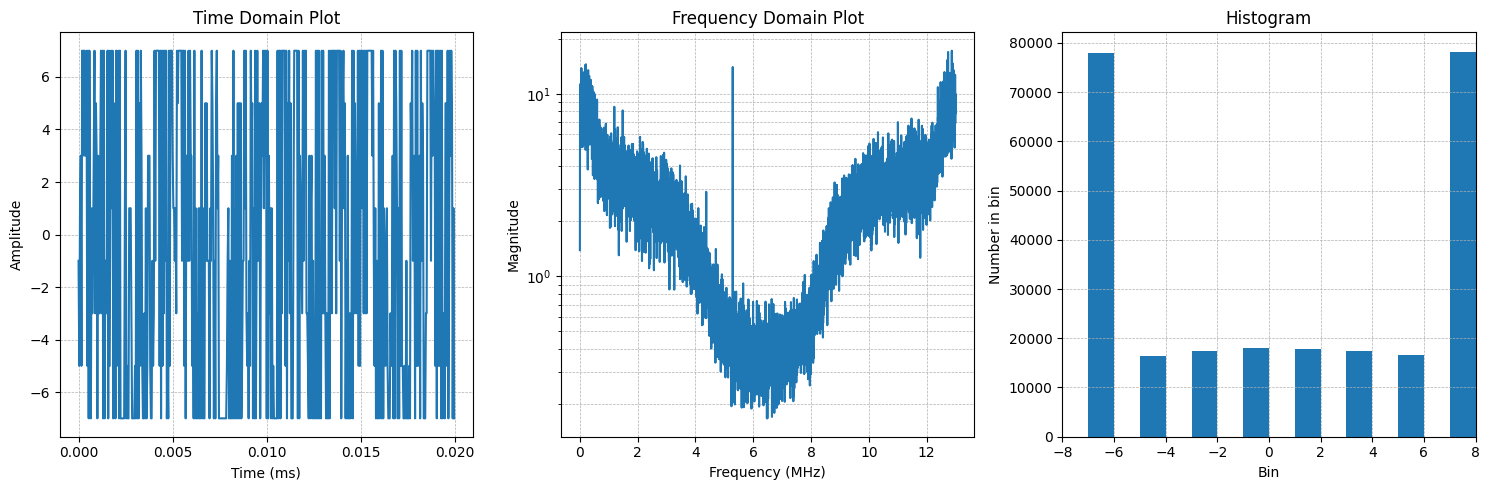

In [26]:
try:
        with open(fileNameStr, 'rb') as fid:
                fid.seek(skipNumberOfBytes, 0)
                samplesPerCode = np.int64(np.round(samplingFreq / (codeFreqBasis / codeLength)))
                try:
                        data = np.fromfile(fid, dataType, 10 * samplesPerCode)
                except IOError:
                    # The file is too short
                    print('Could not read enough data from the data file.')
except IOError as e:
        print('Unable to read file "%s": %s' % (fileNameStr, e))

timeScale = np.arange(0, 0.05, 1 / samplingFreq)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Primeiro subplot: Domínio do Tempo
axs[0].plot(1000 * timeScale[:int(samplesPerCode / 50)], data[:int(samplesPerCode / 50)])
axs[0].set_title('Time Domain Plot')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
axs[0].set_xticks(np.arange(0, 0.025, 0.005)) # type: ignore

# Segundo subplot: Domínio da Frequência
f, Pxx = welch(data - np.mean(data), samplingFreq / 1e6, hamming(16384, False), 16384, 1024, 16384) # type: ignore
axs[1].semilogy(f, Pxx)
axs[1].set_title('Frequency Domain Plot')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Magnitude')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Terceiro subplot: Histograma
dmax = np.max(np.abs(data)) + 1 # type: ignore
axs[2].hist(data, bins=np.arange(-128, 128))
axs[2].set_title('Histogram')
axs[2].set_xlabel('Bin')
axs[2].set_ylabel('Number in bin')
axs[2].set_xlim([-dmax, dmax])
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# Ajustar layout
plt.tight_layout()
plt.show()

In [27]:
print('Starting processing...')
if not fileNameStr:
    fileNameStr = fileName
if not isinstance(fileNameStr, str):
    raise TypeError('File name must be a string')
with open(fileNameStr, 'rb') as fid:
    fid.seek(skipNumberOfBytes, 0)
    if not skipAcquisition:  # or 'acqResults' not in globals():
    # Find number of samples per spreading code
        samplesPerCode = samplesPerCode
        # frequency estimation
        data = np.fromfile(fid, dataType, 11 * samplesPerCode)

Starting processing...


In [28]:
# === Abrir o arquivo de dados ==========================================

try:
    fid = open(fileNameStr, 'rb')
except FileNotFoundError as e:
    print(f"Erro ao abrir o arquivo: {e}")
    exit()

# === Inicializar o multiplicador para ajustar o tipo de dado ===========
if fileType == 1:
    dataAdaptCoeff = 1
else:
    dataAdaptCoeff = 2

In [29]:
# === Se o arquivo foi aberto com sucesso ================================
if fid:

    # Mover o ponto de leitura no arquivo para começar a partir de N bytes
    fid.seek(dataAdaptCoeff * skipNumberOfBytes, os.SEEK_SET)

    # === Aquisição ========================================================

    if skipAcquisition is False:
        
        # Calcular número de amostras por código de espalhamento
        samplesPerCode = round(samplingFreq/(codeFreqBasis/codeLength))

        # Ler 11ms de dados para aquisição
        num_samples = dataAdaptCoeff * 11 * samplesPerCode

        # Ler os dados binários
        data = np.fromfile(fid, dtype=dataType, count=num_samples)

        # Ajustar sinal complexo, se necessário
        if dataAdaptCoeff == 2:
            data1 = data[::2]
            data2 = data[1::2]
            data = data1 + 1j * data2  # cria vetor complexo

    # fid.close()  # fecha o arquivo

In [30]:
def generate_ca_code(prn):
    """
    Gera o código C/A para um satélite GPS específico (PRN 1 a 32).
    
    Parâmetros:
        prn (int): número PRN do satélite (1 a 32)
    
    Retorno:
        ca_code (np.ndarray): vetor com 1023 chips (-1 e 1)
    """
    g2s = [5, 6, 7, 8, 17, 18, 139, 140, 141, 251,
           252, 254, 255, 256, 257, 258, 469, 470, 471, 472,
           473, 474, 509, 512, 513, 514, 515, 516, 859, 860,
           861, 862]

    g2shift = g2s[prn - 1]

    # Geração do registrador G1
    g1 = np.zeros(1023, dtype=int)
    reg = -1 * np.ones(10, dtype=int)
    for i in range(1023):
        g1[i] = reg[9]
        save_bit = reg[2] * reg[9]
        reg[1:10] = reg[0:9]
        reg[0] = save_bit

    # Geração do registrador G2
    g2 = np.zeros(1023, dtype=int)
    reg = -1 * np.ones(10, dtype=int)
    for i in range(1023):
        g2[i] = reg[9]
        save_bit = reg[1] * reg[2] * reg[5] * reg[7] * reg[8] * reg[9]
        reg[1:10] = reg[0:9]
        reg[0] = save_bit

    # Aplica o deslocamento de G2
    g2 = np.concatenate((g2[-g2shift:], g2[:-g2shift]))

    # Combina G1 e G2
    ca_code = -1 * (g1 * g2)  # Resultado: vetor com valores -1 e 1

    return ca_code

In [31]:
def make_ca_table(sampling_freq, code_freq_basis, code_length):
    """
    Gera a tabela com os códigos C/A de todos os 32 satélites GPS,
    amostrados de acordo com os parâmetros de entrada.
    
    Parâmetros:
        settings (dict): deve conter:
            - 'samplingFreq'
            - 'codeFreqBasis'
            - 'codeLength'
    
    Retorno:
        ca_codes_table (np.ndarray): matriz [32 x samplesPerCode]
    """

    samples_per_code = round(sampling_freq / (code_freq_basis / code_length))
    ca_codes_table = np.zeros((32, samples_per_code), dtype=int)

    ts = 1 / sampling_freq
    tc = 1 / code_freq_basis

    for prn in range(1, 33):
        ca_code = generate_ca_code(prn)

        # Criação dos índices de leitura
        code_value_index = np.ceil((ts * np.arange(1, samples_per_code + 1)) / tc).astype(int)
        code_value_index[-1] = 1023  # Corrigir último índice

        ca_codes_table[prn - 1, :] = ca_code[code_value_index - 1]  # Ajusta para indexação 0-based

    return ca_codes_table

In [32]:
# Acquisition initialization =============================================
# Find number of samples per spreading code
samplesPerCode = np.int64(np.round(samplingFreq / (codeFreqBasis / codeLength)))
longSignal = data
# Create two 1m sec vectors of data to correlate with and one with zero DC
signal1 = longSignal[0:samplesPerCode]
signal2 = longSignal[samplesPerCode:2 * samplesPerCode]
signal0DC = longSignal - longSignal.mean()
# Find sampling period
ts = 1.0 / samplingFreq
# Find phase points of the local carrier wave
phasePoints = np.arange(samplesPerCode) * 2 * np.pi * ts
# Number of the frequency bins for the given acquisition band (500Hz steps)
numberOfFrqBins = np.int64(np.round(acqSearchBand * 2/500) + 1)
# código antigo --> numberOfFrqBins = np.int64(np.round(acqSearchBand * 2) + 1)

In [33]:
caCodesTable = np.zeros((32, samplesPerCode))
# --- Find time constants --------------------------------------------------
ts = 1.0 / samplingFreq
tc = 1.0 / codeFreqBasis

In [34]:
# === For all satellite PRN-s ...
for PRN in range(32):
    # --- Generate CA code for given PRN -----------------------------------
    caCode = generate_ca_code(PRN)

    # --- Make index array to read C/A code values -------------------------
    # The length of the index array depends on the sampling frequency -
    # number of samples per millisecond (because one C/A code period is one millisecond).
    codeValueIndex = np.ceil(ts * np.arange(1, samplesPerCode + 1) / tc) - 1
    codeValueIndex = np.longlong(codeValueIndex)
    codeValueIndex[-1] = 1022

    # The "upsampled" code is made by selecting values form the CA code 
    # chip array (caCode) for the time instances of each sample.
    caCodesTable[PRN] = caCode[codeValueIndex]

# Generate all C/A codes and sample them according to the sampling freq.
caCodesTable = make_ca_table(samplingFreq, codeFreqBasis, codeLength)

# --- Initialize arrays to speed up the code -------------------------------
# Search results of all frequency bins and code shifts (for one satellite)
results = np.zeros((numberOfFrqBins, samplesPerCode))

# Carrier frequencies of the frequency bins
frqBins = np.zeros(numberOfFrqBins)

# --- Initialize acqResults ------------------------------------------------
# Carrier frequencies of detected signals
carrFreq = np.zeros(32)

# PRN code phases of detected signals
codePhase_ = np.zeros(32)

# Correlation peak ratios of the detected signals
peakMetric = np.zeros(32)
print(' Perform search for all listed PRN numbers ...')

 Perform search for all listed PRN numbers ...


In [35]:
for PRN in range(len(acqSatelliteList)):
    # Correlate signals, Coarse Acquisition  ======================================================
    # --- Perform DFT of PRN code ------------------------------------------
    caCodeFreqDom = np.fft.fft(caCodesTable[PRN, :]).conj()
    # --- Make the correlation for whole frequency band (for all freq. bins)
    for frqBinIndex in range(numberOfFrqBins):
        # --- Generate carrier wave frequency grid (0.5kHz step) -----------
        # frqBins[frqBinIndex] = IF - acqSearchBand / 2 * 1000 + 500.0 * frqBinIndex
        frqBins[frqBinIndex] = IF - acqSearchBand + 500 * frqBinIndex
        # --- Generate local sine and cosine -------------------------------
        sigCarr = np.exp(1j * frqBins[frqBinIndex] * phasePoints)
        # --- "Remove carrier" from the signal -----------------------------
        I1 = np.real(sigCarr * signal1)
        Q1 = np.imag(sigCarr * signal1)
        I2 = np.real(sigCarr * signal2)
        Q2 = np.imag(sigCarr * signal2)
        # --- Convert the baseband signal to frequency domain --------------
        IQfreqDom1 = np.fft.fft(I1 + 1j * Q1)
        IQfreqDom2 = np.fft.fft(I2 + 1j * Q2)
        # --- Multiplication in the frequency domain (correlation in time domain)
        convCodeIQ1 = IQfreqDom1 * caCodeFreqDom
        convCodeIQ2 = IQfreqDom2 * caCodeFreqDom
        # --- Perform inverse DFT and store correlation results ------------
        acqRes1 = abs(np.fft.ifft(convCodeIQ1))
        acqRes2 = abs(np.fft.ifft(convCodeIQ2))
        # --- Check which msec had the greater power and save that, will 
        # "blend" 1st and 2nd msec but will correct data bit issues
        if acqRes1.max() > acqRes2.max():
            results[frqBinIndex, :] = acqRes1
        else:
            results[frqBinIndex, :] = acqRes2
    # Look for correlation peaks in the results ==============================
    #  Find the highest peak and compare it to the second highest peak
    #  The second peak is chosen not closer than 1 chip to the highest peak
    # --- Find the correlation peak and the carrier frequency --------------
    frequencyBinIndex = results.max(1).argmax()
    # --- Find code phase of the same correlation peak ---------------------
    peakSize = results.max(0).max()
    codePhase = results.max(0).argmax()
    # --- Find 1 chip wide C/A code phase exclude range around the peak ----
    samplesPerCodeChip = np.int64(round(samplingFreq / codeFreqBasis))
    excludeRangeIndex1 = codePhase - samplesPerCodeChip
    excludeRangeIndex2 = codePhase + samplesPerCodeChip
    # --- Correct PRN code phase exclude range if the range includes array boundaries
    if excludeRangeIndex1 <= 0:
        codePhaseRange = np.r_[excludeRangeIndex2:samplesPerCode + excludeRangeIndex1 + 1]
    elif excludeRangeIndex2 >= samplesPerCode - 1:
        codePhaseRange = np.r_[excludeRangeIndex2 - samplesPerCode:excludeRangeIndex1]
    else:
        codePhaseRange = np.r_[0:excludeRangeIndex1 + 1, excludeRangeIndex2:samplesPerCode]
    # --- Find the second highest correlation peak in the same freq. bin ---
    secondPeakSize = results[frequencyBinIndex, codePhaseRange].max()
    # --- Store result -----------------------------------------------------
    peakMetric[PRN] = peakSize / secondPeakSize
    # If the result is above threshold, then there is a signal ...
    if (peakSize / secondPeakSize) > acqThreshold:
    # Fine resolution frequency search =======================================
    # --- Indicate PRN number of the detected signal -------------------
        print('%02d' % (PRN + 1), end=' ')  
        # --- Generate 10msec long C/A codes sequence for given PRN --------
        caCode = generateCAcode(PRN)
        codeValueIndex = np.floor(ts * np.arange(1, 10 * samplesPerCode + 1) / (1.0 / codeFreqBasis))
        longCaCode = caCode[np.longlong(codeValueIndex % 1023)]
        # --- Remove C/A code modulation from the original signal ----------
        # (Using detected C/A code phase)
        xCarrier = signal0DC[codePhase:codePhase + 10 * samplesPerCode] * longCaCode
        # --- Compute the magnitude of the FFT, find maximum and the associated carrier frequency
        # --- Find the next highest power of two and increase by 8x --------
        fftNumPts = 8 * 2 ** (np.ceil(np.log2(len(xCarrier))))
        # --- Compute the magnitude of the FFT, find maximum and the associated carrier frequency
        fftxc = np.abs(np.fft.fft(xCarrier, np.int64(fftNumPts)))
        uniqFftPts = np.int64(np.ceil((fftNumPts + 1) / 2.0))
        fftMaxIndex = np.argmax(fftxc)
        fftFreqBins = np.arange(uniqFftPts) * samplingFreq / fftNumPts
        if fftMaxIndex > uniqFftPts:
            if fftNumPts % 2 == 0: 
                fftFreqBinsRev = -fftFreqBins[uniqFftPts - 2 : 0 : -1]
            else:  
                fftFreqBinsRev = -fftFreqBins[uniqFftPts - 1 : 0 : -1]
            fftMaxIndexRev = np.argmax(fftxc[uniqFftPts:])
            carrFreq[PRN] = fftFreqBinsRev[fftMaxIndexRev]
            carrFreq[PRN] = (-1)**(fileType-1) * carrFreq[PRN]

        else:
            # print(PRN,'ok', fileType)
            # Sinal no lado positivo da FFT
            carrFreq[PRN] = (-1)**(fileType-1) * fftFreqBins[fftMaxIndex]
        # --- Handle IF == 0 edge case ---
        if carrFreq[PRN] == 0:
            carrFreq[PRN] = 1

        # --- Store code phase result ---
        codePhase_[PRN] = codePhase
    else:
        # --- No signal with this PRN --------------------------------------
        print('. ', end=' ')  # Saída na mesma linha para os que falharam
    

.  .  .  .  .  .  .  .  .  .  .  .  .  14 .  16 .  .  .  .  .  .  .  .  .  .  .  .  .  .  31 32 

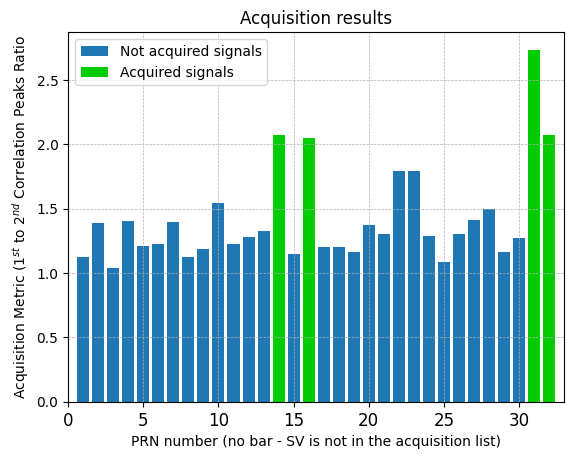


*=========*=====*===============*===========*=============*========*
| Channel | PRN |   Frequency   |  Doppler  | Code Offset | Status |
*=========*=====*===============*===========*=============*========*
|       1 |  31 |  9.91821e+02  |     992   |     19852   |     T  |
|       2 |  32 |  -1.59931e+03 |   -1599   |      8564   |     T  |
|       3 |  14 |  -3.09944e+02 |    -310   |     21543   |     T  |
|       4 |  16 |  1.41335e+03  |    1413   |     13624   |     T  |
|       5 | --- |  ------------ |   -----   |    ------   |   Off  |
|       6 | --- |  ------------ |   -----   |    ------   |   Off  |
|       7 | --- |  ------------ |   -----   |    ------   |   Off  |
|       8 | --- |  ------------ |   -----   |    ------   |   Off  |
|       9 | --- |  ------------ |   -----   |    ------   |   Off  |
|      10 | --- |  ------------ |   -----   |    ------   |   Off  |
|      11 | --- |  ------------ |   -----   |    ------   |   Off  |
|      12 | --- |  ------------ |

In [36]:
# === Acquisition is over ==================================================
acqResults = np.core.records.fromarrays([carrFreq, codePhase_, peakMetric], names='carrFreq,codePhase,peakMetric')
acqResults._results = acqResults
assert isinstance(acqResults._results, np.recarray)
# Plot all results =======================================================
f, hAxes = plt.subplots()

# Plot barra para peakMetric
plt.bar(range(1, 33), acqResults.peakMetric)
plt.title('Acquisition results')
plt.xlabel('PRN number (no bar - SV is not in the acquisition list)')
plt.ylabel('Acquisition Metric ($1^{st}$ to $2^{nd}$ Correlation Peaks Ratio')

oldAxis = plt.axis()
plt.axis([0, 33, 0, oldAxis[-1]])
plt.xticks(range(1, 33), size=12)

# Mark acquired signals ==================================================
# acquiredSignals = acqResults.peakMetric * (acqResults.carrFreq > 0)
acquiredSignals = acqResults.peakMetric * (abs(acqResults.carrFreq) > 0)
# Alterar ticks do eixo X corretamente
hAxes.set_xticks(np.arange(0, 33, 5))  # Modifiquei para hAxes.set_xticks() que é o correto

# Plot barra para sinais adquiridos
plt.bar(range(1, 33), acquiredSignals, color=(0, 0.8, 0))

# Adicionar legenda
plt.legend(['Not acquired signals', 'Acquired signals'])

# Adicionar grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

if np.any(acqResults.carrFreq):
    assert isinstance(acqResults._results, np.recarray)
    PRN = np.zeros(numberOfChannels, dtype='int64')
    acquiredFreq = np.zeros(numberOfChannels)
    codePhase = np.zeros(numberOfChannels)
    status = ['-' for _ in range(numberOfChannels)]
    # --- Copy initial data to all channels ------------------------------------
    # Copy acquisition results ===============================================
    # --- Sort peaks to find strongest signals, keep the peak index information
    PRNindexes = sorted(enumerate(acqResults.peakMetric), key=lambda x: x[-1], reverse=True)
    # --- Load information about each satellite --------------------------------
    # Maximum number of initialized channels is number of detected signals, but
    # not more as the number of channels specified in the settings.
    for ii in range(min(numberOfChannels, sum(abs(acqResults.carrFreq) > 0))):
        PRN[ii] = PRNindexes[ii][0] + 1
        acquiredFreq[ii] = acqResults.carrFreq[PRNindexes[ii][0]]
        codePhase[ii] = acqResults.codePhase[PRNindexes[ii][0]]
        status[ii] = 'T'
    channel = np.core.records.fromarrays([PRN, acquiredFreq, codePhase, status],
                                     names='PRN,acquiredFreq,codePhase,status')
    acqResults._channels = channel
    # Prints the status of all channels in a table.
    # Inputs ================================================
    # channel - data for each channel. It is used to initialize and
    # at the processing of the signal (tracking part).
    # settings    - receiver settings
    channel = acqResults._channels
    # settings = self._settings
    assert isinstance(channel, np.recarray)
    print ('\n*=========*=====*===============*===========*=============*========*')
    print ('| Channel | PRN |   Frequency   |  Doppler  | Code Offset | Status |')
    print ('*=========*=====*===============*===========*=============*========*')
    for channelNr in range(numberOfChannels):
        if channel[channelNr].status != '-' and channel[channelNr].acquiredFreq > 0:
            print('|      %2d | %3d |  %2.5e  |   %5.0f   |    %6d   |     %1s  |' 
                  % (channelNr+1,channel[channelNr].PRN,channel[channelNr].acquiredFreq,channel[channelNr].acquiredFreq - IF,
                     channel[channelNr].codePhase,channel[channelNr].status))
        elif channel[channelNr].status != '-' and channel[channelNr].acquiredFreq < 0:
            print('|      %2d | %3d |  %2.5e |   %5.0f   |    %6d   |     %1s  |' 
                  % (channelNr+1,channel[channelNr].PRN,channel[channelNr].acquiredFreq,channel[channelNr].acquiredFreq - IF,
                     channel[channelNr].codePhase,channel[channelNr].status))
        else:
            channelNr = channelNr+1
            print('|      %2d | --- |  ------------ |   -----   |    ------   |   Off  |' % channelNr)
    print('*=========*=====*===============*===========*=============*========*\n')
else:
    # No satellites to track, exit
    print('No GNSS signals detected, signal processing finished.')
    trackResults = None


In [37]:
data_settings = scipy.io.loadmat(r'C:\Repository\Scripts_general\GPSL1-DPEmodule\settings_dpe_sim.mat')
settings = data_settings['settings']

In [38]:
data_track = scipy.io.loadmat(r'C:\Repository\Scripts_general\GPSL1-DPEmodule\trackResults_dpe_sim.mat')
trackResults = data_track['trackResults']

In [39]:
data_nav = scipy.io.loadmat(r'C:\Repository\Scripts_general\GPSL1-DPEmodule\navSolutions_dpe_sim.mat')
navSolutions = data_nav['navSolutions']

In [40]:
fid = 4

In [41]:
settings_msToProcess = settings[0][0][0][0][0]

In [42]:
trackResults_status = []
trackResults_absoluteSample = []
trackResults_codeFreq = []
trackResults_carrFreq = []
trackResults_I_P = []
trackResults_I_E = []
trackResults_I_L = []
trackResults_Q_E = []
trackResults_Q_P = []
trackResults_Q_L = []
trackResults_dllDiscr = []
trackResults_dllDiscrFilt = []
trackResults_pllDiscr = []
trackResults_pllDiscrFilt = []
trackResults_remCodePhase = []
trackResults_remCarrPhase = []
trackResults_CNo = []
trackResults_PRN = []
for i in range(numberOfChannels):
    trackResults_status.append(trackResults[0][i][0][0])
    trackResults_absoluteSample.append(trackResults[0][i][1][0])
    try:
           trackResults_codeFreq.append(trackResults[0][i][2][0])
    except:
         trackResults_codeFreq.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_carrFreq.append(trackResults[0][i][3][0])
    except:
         trackResults_carrFreq.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_I_P.append(trackResults[0][i][4][0])
    except:
         trackResults_I_P.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_I_E.append(trackResults[0][i][5][0])
    except:
         trackResults_I_E.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_I_L.append(trackResults[0][i][6][0])
    except:
         trackResults_I_L.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_Q_E.append(trackResults[0][i][7][0])
    except:
         trackResults_Q_E.append([]) 
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_Q_P.append(trackResults[0][i][8][0])
    except:
         trackResults_Q_P.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_Q_L.append(trackResults[0][i][9][0])
    except:
         trackResults_Q_L.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_dllDiscr.append(trackResults[0][i][10][0])
    except:
         trackResults_dllDiscr.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_dllDiscrFilt.append(trackResults[0][i][11][0])
    except:
         trackResults_dllDiscrFilt.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_pllDiscr.append(trackResults[0][i][12][0])
    except:
         trackResults_pllDiscr.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_pllDiscrFilt.append(trackResults[0][i][13][0])
    except:
         trackResults_pllDiscrFilt.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_remCodePhase.append(trackResults[0][i][14][0])
    except:
         trackResults_remCodePhase.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_remCarrPhase.append(trackResults[0][i][15][0])
    except:
         trackResults_remCarrPhase.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_CNo.append(trackResults[0][i][16][0][0])
    except:
         trackResults_CNo.append([])
################################################################

for i in range(numberOfChannels):
    try:
           trackResults_PRN.append(trackResults[0][i][17][0][0])
    except:
         trackResults_PRN.append([])

In [43]:
navSolutions_PRN = np.zeros([4,168])
navSolutions_PRN[0,:] = navSolutions[0][0][0][0]
navSolutions_PRN[1,:] = navSolutions[0][0][0][1]
navSolutions_PRN[2,:] = navSolutions[0][0][0][2]
navSolutions_PRN[3,:] = navSolutions[0][0][0][3]
################################################
navSolutions_el = np.zeros([12,168])
navSolutions_el[0,:] = navSolutions[0][0][1][0]
navSolutions_el[1,:] = navSolutions[0][0][1][1]
navSolutions_el[2,:] = navSolutions[0][0][1][2]
navSolutions_el[3,:] = navSolutions[0][0][1][3]
navSolutions_el[4,:] = navSolutions[0][0][1][4]
navSolutions_el[5,:] = navSolutions[0][0][1][5]
navSolutions_el[6,:] = navSolutions[0][0][1][6]
navSolutions_el[7,:] = navSolutions[0][0][1][7]
navSolutions_el[8,:] = navSolutions[0][0][1][8]
navSolutions_el[9,:] = navSolutions[0][0][1][9]
navSolutions_el[10,:] = navSolutions[0][0][1][10]
navSolutions_el[11,:] = navSolutions[0][0][1][11]
################################################
navSolutions_az = np.zeros([12,168])
navSolutions_az[0,:] = navSolutions[0][0][2][0]
navSolutions_az[1,:] = navSolutions[0][0][2][1]
navSolutions_az[2,:] = navSolutions[0][0][2][2]
navSolutions_az[3,:] = navSolutions[0][0][2][3]
navSolutions_az[4,:] = navSolutions[0][0][2][4]
navSolutions_az[5,:] = navSolutions[0][0][2][5]
navSolutions_az[6,:] = navSolutions[0][0][2][6]
navSolutions_az[7,:] = navSolutions[0][0][2][7]
navSolutions_az[8,:] = navSolutions[0][0][2][8]
navSolutions_az[9,:] = navSolutions[0][0][2][9]
navSolutions_az[10,:] = navSolutions[0][0][2][10]
navSolutions_az[11,:] = navSolutions[0][0][2][11]
################################################
navSolutions_transmitTime = np.zeros([12,168])
navSolutions_transmitTime[0,:] = navSolutions[0][0][3][0]
navSolutions_transmitTime[1,:] = navSolutions[0][0][3][1]
navSolutions_transmitTime[2,:] = navSolutions[0][0][3][2]
navSolutions_transmitTime[3,:] = navSolutions[0][0][3][3]
navSolutions_transmitTime[4,:] = navSolutions[0][0][3][4]
navSolutions_transmitTime[5,:] = navSolutions[0][0][3][5]
navSolutions_transmitTime[6,:] = navSolutions[0][0][3][6]
navSolutions_transmitTime[7,:] = navSolutions[0][0][3][7]
navSolutions_transmitTime[8,:] = navSolutions[0][0][3][8]
navSolutions_transmitTime[9,:] = navSolutions[0][0][3][9]
navSolutions_transmitTime[10,:] = navSolutions[0][0][3][10]
navSolutions_transmitTime[11,:] = navSolutions[0][0][3][11]
###########################################################
navSolutions_satClkCorr = np.zeros([12,168])
navSolutions_satClkCorr[0,:] = navSolutions[0][0][4][0]
navSolutions_satClkCorr[1,:] = navSolutions[0][0][4][1]
navSolutions_satClkCorr[2,:] = navSolutions[0][0][4][2]
navSolutions_satClkCorr[3,:] = navSolutions[0][0][4][3]
navSolutions_satClkCorr[4,:] = navSolutions[0][0][4][4]
navSolutions_satClkCorr[5,:] = navSolutions[0][0][4][5]
navSolutions_satClkCorr[6,:] = navSolutions[0][0][4][6]
navSolutions_satClkCorr[7,:] = navSolutions[0][0][4][7]
navSolutions_satClkCorr[8,:] = navSolutions[0][0][4][8]
navSolutions_satClkCorr[9,:] = navSolutions[0][0][4][9]
navSolutions_satClkCorr[10,:] = navSolutions[0][0][4][10]
navSolutions_satClkCorr[11,:] = navSolutions[0][0][4][11]
###########################################################
navSolutions_rawP = np.zeros([12,168])
navSolutions_rawP[0,:] = navSolutions[0][0][5][0]
navSolutions_rawP[1,:] = navSolutions[0][0][5][1]
navSolutions_rawP[2,:] = navSolutions[0][0][5][2]
navSolutions_rawP[3,:] = navSolutions[0][0][5][3]
navSolutions_rawP[4,:] = navSolutions[0][0][5][4]
navSolutions_rawP[5,:] = navSolutions[0][0][5][5]
navSolutions_rawP[6,:] = navSolutions[0][0][5][6]
navSolutions_rawP[7,:] = navSolutions[0][0][5][7]
navSolutions_rawP[8,:] = navSolutions[0][0][5][8]
navSolutions_rawP[9,:] = navSolutions[0][0][5][9]
navSolutions_rawP[10,:] = navSolutions[0][0][5][10]
navSolutions_rawP[11,:] = navSolutions[0][0][5][11]
###########################################################


In [44]:
navSolutions_DOP = np.zeros([12,168])
navSolutions_DOP[0,:] = navSolutions[0][0][6][0]
navSolutions_DOP[1,:] = navSolutions[0][0][6][1]
navSolutions_DOP[2,:] = navSolutions[0][0][6][2]
navSolutions_DOP[3,:] = navSolutions[0][0][6][3]
navSolutions_DOP[4,:] = navSolutions[0][0][6][4]


In [45]:
# navSolutions_DOP[5,:] = navSolutions[0][0][6][5]
# navSolutions_DOP[6,:] = navSolutions[0][0][6][6]
# navSolutions_DOP[7,:] = navSolutions[0][0][6][7]
# navSolutions_DOP[8,:] = navSolutions[0][0][6][8]
# navSolutions_DOP[9,:] = navSolutions[0][0][6][9]
# navSolutions_DOP[10,:] = navSolutions[0][0][6][10]
# navSolutions_DOP[11,:] = navSolutions[0][0][6][11]
###########################################################
navSolutions_X = navSolutions[0][0][7][0]
navSolutions_Y = navSolutions[0][0][8][0]
navSolutions_Z = navSolutions[0][0][9][0]
navSolutions_dt = navSolutions[0][0][10][0]
navSolutions_currMeasSample = navSolutions[0][0][11][0]
navSolutions_correctedP = navSolutions[0][0][12][0]
navSolutions_latitude = navSolutions[0][0][13][0]
navSolutions_longitude = navSolutions[0][0][14][0]
navSolutions_height = navSolutions[0][0][15][0]
navSolutions_utmZone = navSolutions[0][0][16][0][0]
navSolutions_E = navSolutions[0][0][17][0]
navSolutions_N = navSolutions[0][0][18][0]
navSolutions_U = navSolutions[0][0][19][0]
navSolutions_DPE_estimate = np.zeros([168,5])
for i in range(0,168):
    # print(i)
    navSolutions_DPE_estimate[i,:] = navSolutions[0][0][20][i]
navSolutions_DPE_latitude = navSolutions[0][0][21][0]
navSolutions_DPE_longitude = navSolutions[0][0][22][0]
navSolutions_DPE_height = navSolutions[0][0][23][0]
navSolutions_DPE_clkBias = navSolutions[0][0][24][0]
navSolutions_DPE_processingtime = navSolutions[0][0][25][0]
navSolutions_localTime = navSolutions[0][0][26][0]


In [46]:
navSolutions_LLH_error = np.zeros([168,4])
for i in range(0,168):
    navSolutions_LLH_error[i,:] = navSolutions[0][0][27][i]

In [47]:
if (settings_msToProcess < 36000): 
    # Show the error message and exit
    print('Record is to short. Exiting!');
    navSolutions = []
    eph          = []

In [48]:
# Pré-alocação de espaço
subFrameStart = np.full(numberOfChannels, np.inf)
TOW = np.full(numberOfChannels, np.inf)
# Lista de canais ativos (que estão em rastreamento)
ch_status = []
for i in range(numberOfChannels):
    try:
        ch_status.append(trackResults[0][i][0][0])
    except Exception as e:
        print(f'Elemento status {i}: erro ({e})')
activeChnList = [i for i, ch in enumerate(ch_status) if ch != '-']
data_ephem = scipy.io.loadmat(r'C:\Repository\Scripts_general\GPSL1-DPEmodule\eph_dpe_sim.mat')
eph_test = data_ephem['eph']

In [49]:
for channelNr in activeChnList:
    PRN = trackResults_PRN[channelNr]
    print(f'Decoding NAV for PRN {PRN:02d} -------------------- ')
# Fazer o código certo depois para ephem

Decoding NAV for PRN 31 -------------------- 
Decoding NAV for PRN 32 -------------------- 
Decoding NAV for PRN 14 -------------------- 
Decoding NAV for PRN 16 -------------------- 


In [50]:
subFrameStart[0] = 1294
subFrameStart[1] = 1292
subFrameStart[2] = 1294
subFrameStart[3] = 1291
TOW[0] = 119652
TOW[1] = 119652
TOW[2] = 119652
TOW[3] = 119652


In [ ]:
# Supondo que settings seja um dicionário ou objeto com atributo numberOfChannels
# settings_numberOfChannels = settings[0][0][1][0][0]
settings_numberOfChannels = numberOfChannels
number_of_channels = settings_numberOfChannels
sample_start = np.zeros(number_of_channels)
sample_end = np.full(number_of_channels, np.inf)
active_chn_list = [0, 1, 2, 3]
for channelNr in activeChnList:
    print(f'Decoding NAV for PRN {PRN:02d} -------------------- ')
    sample_start[channelNr] = trackResults_absoluteSample[channelNr][int(subFrameStart[channelNr])-1]
    sample_end[channelNr] = trackResults_absoluteSample[channelNr][-1]
    # print(sample_end[channelNr])

sample_start = np.max(sample_start)+1
sample_end = np.min(sample_end)-1
meas_sample_step = int(samplingFreq * navSolPeriod / 1000)
meas_nr_sum = int((sample_end - sample_start) / meas_sample_step)
sat_elev = np.full(number_of_channels, np.inf)
ready_chn_list = active_chn_list.copy()
local_time = np.inf
meas_nr_sum = 4 # Teste
for curr_meas_nr in range(0, meas_nr_sum):
    print(f"Fix: Processing {curr_meas_nr+1:02d} of {meas_nr_sum:02d}")
    active_chn_list = list(np.intersect1d(np.where(sat_elev >= elevationMask)[0], ready_chn_list))
    navSolutions_PRN[:,curr_meas_nr] = np.array([trackResults_PRN[i] for i in active_chn_list])
    navSolutions_el[:,curr_meas_nr] = np.full(number_of_channels, np.nan)
    navSolutions_az[:,curr_meas_nr] = np.full(number_of_channels, np.nan)
    navSolutions_transmitTime[:,curr_meas_nr] = np.full(number_of_channels, np.nan)
    navSolutions_satClkCorr[:,curr_meas_nr] = np.full(number_of_channels, np.nan)
    currMeasSample = sample_start + meas_sample_step*(curr_meas_nr)
    ##############################################################################################################vv
    # Calcula Pseudorange
    transmitTime = np.full(number_of_channels, np.inf)
    codePhase = np.zeros([len(active_chn_list),1])
    for channelNr in activeChnList:
        # Encontra o índice de I_P no qual a integração contem a localização da medida atual 
        for index in range(len(trackResults_absoluteSample[channelNr])):
            if trackResults_absoluteSample[channelNr][index] > currMeasSample:
                break
        index -= 1
        # Atualiza o phasestep baseado no code freq e na sampling frequency
        codePhaseStep = trackResults_codeFreq[channelNr][index] /samplingFreq
        # Code phase a partir do código PRN para a localização da amostra da medida atual
        codePhase[channelNr]  = trackResults_remCodePhase[channelNr][index] + codePhaseStep*(currMeasSample-trackResults_absoluteSample[channelNr][index])
        # Transmitting Time (em unidade s) na localização da medida atual
        transmitTime[channelNr] = (codePhase[channelNr][0]/codeLength/DPE_cohInt + index + 1 - subFrameStart[channelNr])*codeLength*DPE_cohInt/codeFreqBasis +TOW[channelNr]
    if local_time == np.inf:
        max_time = np.max(transmitTime[active_chn_list])
        local_time = max_time + (startOffset / 1000)  # converte ms para s
    # --- Converte o intervalo de tempo de ida e volta para distância ------------------------------------
    # Converte a velocidade da luz c de m/s para m/ms
    pseudoranges    = (local_time - transmitTime) * c
    navSolutions_rawP[:,curr_meas_nr] = pseudoranges
    navSolutions_transmitTime[active_chn_list,curr_meas_nr]  = transmitTime[active_chn_list]
    transmitTime = transmitTime[active_chn_list]
    prn_list = [trackResults_PRN[i] for i in active_chn_list]
    eph = eph_test
    ##########################################################################
    # Cálculo das coordenadas X, Y, Z no TRANSMITTIME para as efemérides EPH consideradas.
    # Coordenadas são calculadas para cada satélite na lista prn_list
    # Calculation of X,Y,Z satellites coordinates at TRANSMITTIME for
    # Inicialização de constantes ===================================================
    numOfSatellites = len(prn_list)
    # GPS constantes
    gpsPi = 3.1415926535898  # valor de Pi usado no sistema de coordenadas GPS
    # --- Constantes para o cálculo da posição do satélite
    Omegae_dot     = 7.2921151467e-5 # Earth rotation rate, [rad/s]
    GM             = 3.986005e14 # Earth's universal gravitational constant, [m^3/s^2]
    F              = -4.442807633e-10 # Constant, [sec/(meter)^(1/2)]
    # Inicialização de resultados ===================================================
    satClkCorr   = np.zeros([1,numOfSatellites])
    satPositions = np.zeros([3,numOfSatellites])
    # Processamento em cada satélite da lista =================================================
    for satNr in range(0,numOfSatellites):        
        prn = prn_list[satNr]
        # Encontra a correção inicial de clock do satélite --------------------------------
        # --- Encontra a diferença de tempo
        time = transmitTime[satNr] - eph[0][prn-1][15][0][0]
        half_week = 302400  # seconds
        corrTime = time
        if time > half_week:
            corrTime = time - 2*half_week
        elif time < -half_week:
            corrTime = time + 2*half_week
        dt = corrTime
        # --- Calculate clock correction ---------------------------------------
        satClkCorr[:,satNr] = (eph[0][prn-1][16][0][0] * dt + eph[0][prn-1][17][0][0]) * dt + eph[0][prn-1][18][0][0] - eph[0][prn-1][13][0][0]
        time = transmitTime[satNr] - satClkCorr[:,satNr][0]
        # Find satellite's position ----------------------------------------------
        # Restore semi-major axis
        a   = eph[0][prn-1][26][0][0] * eph[0][prn-1][26][0][0]
        # Time correction
        time = time - eph[0][prn-1][27][0][0]
        half_week = 302400 # seconds
        corrTime = time
        if time > half_week:
            corrTime = time - 2*half_week
        elif time < -half_week:
            corrTime = time + 2*half_week
        tk = corrTime
        # Initial mean motion
        n0  = np.sqrt(GM / a**3)
        # Mean motion        
        n   = n0 + eph[0][prn-1][21][0][0]
        # Mean anomaly
        M   = eph[0][prn-1][22][0][0] + (n * tk)        
        # Reduce mean anomaly to between 0 and 360 deg
        M = (M + 2 * gpsPi) % (2 * gpsPi)
        # Initial guess of eccentric anomaly
        E   = M 
        # --- Iteratively compute eccentric anomaly ----------------------------        
        for ii in range(10):
            E_old = E
            E = M + eph[0][prn-1][24][0][0] * np.sin(E)
            dE = (E - E_old) % (2 * gpsPi)

            if np.abs(dE) < 1.e-12:
                # Necessary precision is reached, exit from the loop
                break
        # Reduce eccentric anomaly to between 0 and 360 deg
        # E   = rem(E + 2*gpsPi, 2*gpsPi);
        E = (E + 2*gpsPi) % (2 * gpsPi)
        
        # Relativistic correction
        dtr = F * eph[0][prn-1][24][0][0] * eph[0][prn-1][26][0][0] * np.sin(E)

        # Calculate the true anomaly
        nu = np.arctan2(np.sqrt(1 - eph[0][prn-1][24][0][0]**2) * np.sin(E),
                        np.cos(E) - eph[0][prn-1][24][0][0])

        # Compute angle phi
        phi = nu + eph[0][prn-1][5][0][0]
        
        # Reduce phi to between 0 and 360 deg
        # phi = phi % (2 * gpsPi)
        # print(phi)
        
        # Correct argument of latitude
        u = phi + eph[0][prn-1][23][0][0] * np.cos(2*phi) + eph[0][prn-1][25][0][0] * np.sin(2*phi)    
        
        # Correct radius
        r = a * (1 - eph[0][prn-1][24][0][0]*np.cos(E)) + eph[0][prn-1][4][0][0] * np.cos(2*phi) + eph[0][prn-1][20][0][0] * np.sin(2*phi)
        # Correct inclination
        i = eph[0][prn-1][3][0][0] + eph[0][prn-1][8][0][0] * tk + eph[0][prn-1][0][0][0] * np.cos(2*phi) + eph[0][prn-1][2][0][0] * np.sin(2*phi)
        # 2.9 SV position in orbital plane
        xk1 = np.cos(u)*r
        yk1 = np.sin(u)*r
        
        # Compute the angle between the ascending node and the Greenwich meridian
        Omega = eph[0][prn-1][1][0][0] + (eph[0][prn-1][6][0][0] - Omegae_dot)*tk - Omegae_dot * eph[0][prn-1][27][0][0]
        
        # Reduce to between 0 and 360 deg
        Omega = (Omega + 2 * gpsPi) - 2 * gpsPi * np.fix((Omega + 2 * gpsPi) / (2 * gpsPi))
        
        # --- Compute satellite coordinates ------------------------------------
        xk = xk1 * np.cos(Omega) - yk1 * np.cos(i)*np.sin(Omega)
        yk = xk1 * np.sin(Omega) + yk1 * np.cos(i)*np.cos(Omega);
        zk = yk1 * np.sin(i)
        satPositions[0,satNr] = xk
        satPositions[1,satNr] = yk
        satPositions[2,satNr] = zk
        
        # Include relativistic correction in clock correction --------------------
        satClkCorr[:,satNr] = (eph[0][prn-1][16][0][0] * dt + 
                               eph[0][prn-1][17][0][0]) * dt + \
                               eph[0][prn-1][18][0][0] - \
                                eph[0][prn-1][13][0][0] + dtr       
    
    ##########################################################################
    navSolutions_satClkCorr[active_chn_list,curr_meas_nr] = satClkCorr

Decoding NAV for PRN 16 -------------------- 
Decoding NAV for PRN 16 -------------------- 
Decoding NAV for PRN 16 -------------------- 
Decoding NAV for PRN 16 -------------------- 
Fix: Processing 01 of 04
Fix: Processing 02 of 04
Fix: Processing 03 of 04
Fix: Processing 04 of 04


In [52]:
data_nav = scipy.io.loadmat('navSolutions2.mat')
navSolutions = data_nav['navSolutions']

In [53]:
PRN_nav = []
for i in range(len(navSolutions[0][0][0])):
        PRN_nav.append(navSolutions[0][0][0][i])

In [54]:
ls_2d_list = navSolutions[0][0][27][:,0]
dpe_2d_list = navSolutions[0][0][27][:,1]
ls_3d_list = navSolutions[0][0][27][:,2]
dpe_3d_list = navSolutions[0][0][27][:,3]

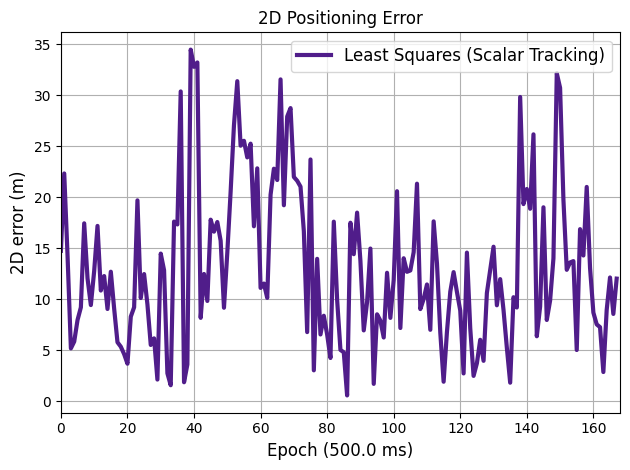

In [59]:
# === Plot 2D positioning error ===========================================
plt.figure()

ab, = plt.plot(ls_2d_list, color='#501D8A', linewidth=3, label='Least Squares (Scalar Tracking)')
# bc, = plt.plot(dpe_2d_list, color='#FF9200', linewidth=3, label='DPE')

plt.legend(fontsize=12)
label_xaxis = f"Epoch ({navSolPeriod} ms)"
plt.xlabel(label_xaxis, fontsize=12)
plt.ylabel('2D error (m)', fontsize=12)
plt.xlim([0, len(ls_2d_list)])
len(ls_2d_list)
plt.title(f"2D Positioning Error")
plt.grid(True)
plt.tight_layout()
plt.show()


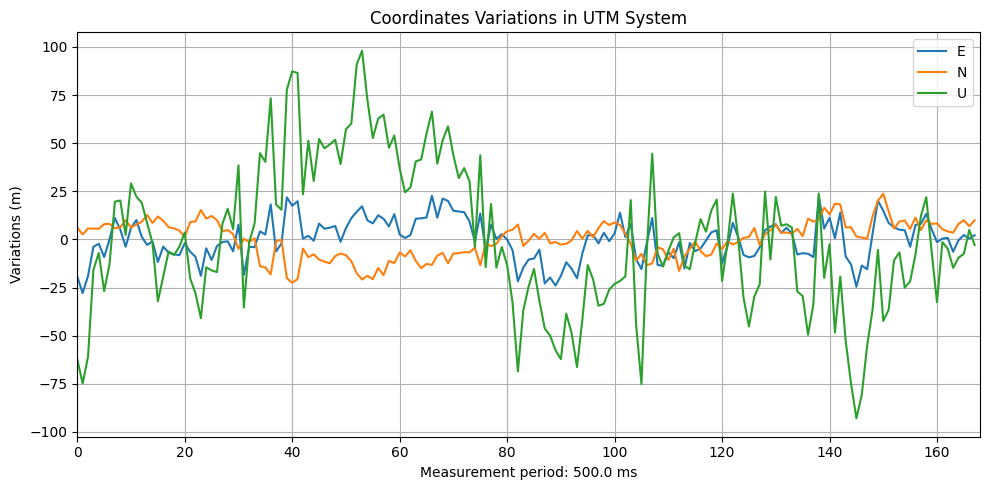

In [58]:
navSolutions_E = navSolutions[0][0][17][0]
navSolutions_N = navSolutions[0][0][18][0]
navSolutions_U = navSolutions[0][0][19][0]
refCoord_E = np.mean(navSolutions_E[~np.isnan(navSolutions_E)])
refCoord_N = np.mean(navSolutions_N[~np.isnan(navSolutions_N)])
refCoord_U = np.mean(navSolutions_U[~np.isnan(navSolutions_U)])
# Criação da figura
plt.figure(figsize=(10, 5))  # Ajuste de tamanho para melhor visualização
plt.plot(navSolutions_E - refCoord_E, label='E')
plt.plot(navSolutions_N - refCoord_N, label='N')
plt.plot(navSolutions_U - refCoord_U, label='U')
plt.xlim([0, len(navSolutions_E)])
# Configurações do gráfico
plt.title('Coordinates Variations in UTM System')
plt.xlabel(f'Measurement period: {navSolPeriod} ms')
plt.ylabel('Variations (m)')
plt.legend()
plt.grid()
plt.tight_layout()  # Ajuste para evitar sobreposição
plt.show() 